In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
plt.rcParams["figure.dpi"] = 150

In [2]:
world_avg_inflation = {
    2018: 2.4503624385017,
    2019: 2.20607305781525,
    2020: 1.93694126694223,
    2021: 3.44527766461135,
    2022: 7.98518671835033,
    2023: 5.80113321465538
}

def fill_inflation(row):
    if pd.isna(row['inflation']):
        return world_avg_inflation.get(row['year'], row['inflation'])
    else:
        return row['inflation']

def correct_name(row):
    if country_dict.get(row['Country Code']):
        return country_dict.get(row['Country Code'])
    return row['country']


def correct_rate(row):
    if row["vacc_rate"] > 100:
        return 100
    return row["vacc_rate"]

### Trade Data

In [3]:
trade_data = pd.read_excel("TradeData.xlsx")
country_dict = dict(zip(trade_data['PartnerISO'], trade_data['PartnerDesc']))

all_trade_value = trade_data.pivot_table(index=['RefYear', 'PartnerDesc'], columns='CmdDesc', values='Fobvalue', aggfunc='sum').reset_index()
all_trade_value = all_trade_value.rename(columns={'RefYear': 'year', 'PartnerDesc': 'country'})
all_trade_value['all_trade'] = all_trade_value.drop(columns=['year', 'country']).sum(axis=1)
all_trade_value.rename_axis(columns=None, inplace=True)
all_trade_value.rename(columns={"Dairy produce; birds' eggs; natural honey; edible products of animal origin, not elsewhere specified or included": "dairy_produce", "Fish and crustaceans, molluscs and other aquatic invertebrates": "aquatic_produce", "Fruit and nuts, edible; peel of citrus fruit or melons": "fruit_produce", "Meat and edible meat offal": "meat_produce", "Vegetables and certain roots and tubers; edible": "vegetable_produce"}, inplace=True)
all_trade_value_for_save = all_trade_value.fillna(0)
all_trade_value.replace(np.nan, 1, inplace=True)
all_trade_value.head(10)

,year,country,dairy_produce,aquatic_produce,fruit_produce,meat_produce,vegetable_produce,all_trade
0,2018,Afghanistan,8.361214e+05,1.000000e+00,2.369273e+05,1.000000e+00,1.000000e+00,1.073049e+06
1,2018,Albania,1.000000e+00,5.929350e+04,1.000000e+00,1.000000e+00,1.000000e+00,5.929350e+04
2,2018,Algeria,3.376288e+08,1.000000e+00,1.000000e+00,1.000000e+00,2.355260e+06,3.399840e+08
3,2018,American Samoa,9.998871e+05,1.341764e+05,7.746890e+02,1.527831e+06,1.330026e+05,2.795671e+06
4,2018,Angola,4.156789e+06,8.648376e+05,1.000000e+00,1.000000e+00,1.000000e+00,5.021627e+06
5,2018,Antigua and Barbuda,5.470253e+05,1.000000e+00,1.000000e+00,1.538887e+05,1.000000e+00,7.009140e+05
6,2018,Argentina,1.000000e+00,1.000000e+00,2.972754e+05,1.000000e+00,4.011336e+03,3.012868e+05
7,2018,Armenia,3.078835e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.078835e+06
8,2018,Aruba,9.282838e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.282838e+05
9,2018,Australia,5.631385e+08,1.452564e+08,1.179896e+08,3.053623e+07,5.144362e+07,9.083643e+08


### GDP

In [4]:
overall_gdp = pd.read_excel("GDP.xlsx",sheet_name="overall_gdp").drop(columns="Unnamed: 1")
average_gdp = pd.read_excel("GDP.xlsx",sheet_name="average_gdp").drop(columns="Unnamed: 1")
overall_gdp = overall_gdp.melt(id_vars=["Country Name"], var_name="Year", value_name="GDP")
average_gdp = average_gdp.melt(id_vars=["Country Name"], var_name="Year", value_name="avg_GDP")
overall_gdp = overall_gdp.rename(columns={"Country Name": "country", "Year": "year"})
average_gdp = average_gdp.rename(columns={"Country Name": "country", "Year": "year"})
overall_gdp.year = overall_gdp.year.astype(int)
average_gdp.year = average_gdp.year.astype(int)

In [5]:
overall_gdp.head()

,country,year,GDP
0,Aruba,2018,3.276184e+09
1,Afghanistan,2018,1.805322e+10
2,Angola,2018,7.945069e+10
3,Albania,2018,1.515642e+10
4,United Arab Emirates,2018,4.270494e+11


In [6]:
average_gdp.head()

,country,year,avg_GDP
0,Aruba,2018,30918.483584
1,Afghanistan,2018,492.090631
2,Angola,2018,2540.508879
3,Albania,2018,5287.660801
4,United Arab Emirates,2018,46722.268719


### FTA

In [7]:
fta = pd.read_excel("FTA.xlsx").drop(columns="Unnamed: 0")
fta = fta.melt(id_vars=["年份"], var_name="Year", value_name="FTA")
fta = fta.rename(columns={"年份": "country", "Year": "year"})
fta.year = fta.year.astype(int)
fta.head()

,country,year,FTA
0,Aruba,2018,0
1,Afghanistan,2018,0
2,Angola,2018,0
3,Albania,2018,0
4,United Arab Emirates,2018,0


### Freight

In [8]:
freight = pd.read_excel("Freight.xlsx")
freight.replace(0, np.nan, inplace=True)
freight.update(freight.iloc[:, 1:-1].apply(lambda x: x.fillna(x.mean()), axis=0))
freight['country'] = freight.apply(correct_name, axis=1)
freight = freight.drop(columns="Country Code")
freight = freight.melt(id_vars=["country"], var_name="Year", value_name="Freight")
freight = freight.rename(columns={"Year": "year", "Freight": "freight"})
freight.year = freight.year.astype(int)
freight.head()

,country,year,freight
0,Afghanistan,2018,29.167851
1,Albania,2018,8.554160
2,Algeria,2018,21.337823
3,American Samoa,2018,21.337823
4,Angola,2018,4.421110


### Inflation

In [9]:
inflation = pd.read_excel("Inflation.xlsx")[["Country Name", "Time", "Inflation, consumer prices (annual %) [FP.CPI.TOTL.ZG]", "Country Code"]]
inflation = inflation.rename(columns={"Time": "year", "Inflation, consumer prices (annual %) [FP.CPI.TOTL.ZG]": "inflation", "Country Name": "country"})
inflation.replace("..", np.nan, inplace=True)
inflation['inflation'] = inflation.apply(fill_inflation, axis=1)
inflation['country'] = inflation.apply(correct_name, axis=1)
inflation.head()

,country,year,inflation,Country Code
0,Afghanistan,2018,0.626149,AFG
1,Afghanistan,2019,2.302373,AFG
2,Afghanistan,2020,1.936941,AFG
3,Afghanistan,2021,3.445278,AFG
4,Afghanistan,2022,7.985187,AFG


### vaccinated rate

In [10]:
covid_vacc = pd.read_excel("vaccinated_rates.xlsx")
covid_vacc[2018] = 0
covid_vacc[2019] = 0
covid_vacc[2020] = covid_vacc[2019] + covid_vacc[2020]
covid_vacc[2021] = covid_vacc[2020] + covid_vacc[2021]
covid_vacc[2022] = covid_vacc[2021] + covid_vacc[2022]
covid_vacc[2023] = covid_vacc[2022] + covid_vacc[2023]
covid_vacc.drop(columns="总计", inplace=True)
covid_vacc.replace(np.nan, 0, inplace=True)
covid_vacc = covid_vacc.melt(id_vars=["location"], var_name="year", value_name="vacc_rate")
covid_vacc = covid_vacc.rename(columns={"location": "country"})
covid_vacc["vacc_rate"] = covid_vacc.apply(correct_rate, axis=1)
covid_vacc.year = covid_vacc.year.astype(int)
covid_vacc.head()

,country,year,vacc_rate
0,Afghanistan,2020,0.0
1,Albania,2020,0.0
2,Algeria,2020,0.0
3,American Samoa,2020,0.0
4,Angola,2020,0.0


### Covid death rate

In [11]:
covid_death_rate= pd.read_excel("covid_death_rate.xls",sheet_name="covid_death_rate")[["Year", "Country", "death rate"]]
covid_death_rate = covid_death_rate.rename(columns={"Country": "country", "Year": "year", "death rate": "death_rate"})
countries = covid_death_rate['country'].unique()
new_years = pd.DataFrame({
    'country': list(countries) * 2,  # 重复国家列表两次，因为有两个新年份
    'year': [2018, 2019] * len(countries),
    'death_rate': 0
})
covid_death_rate = pd.concat([covid_death_rate, new_years], ignore_index=True)
covid_death_rate.head()

,year,country,death_rate
0,2020,Aruba,0.000441
1,2021,Aruba,0.001700
2,2022,Aruba,0.002630
3,2023,Aruba,0.002750
4,2020,Afghanistan,0.000055


### Continent

In [12]:
continent = pd.read_excel("continent.xlsx")
continent.head(10)
continent = continent[["Year", "Country","Asia", "Africa", "North_America", "South_America", "Europe", "Oceania"]]
continent = continent.rename(columns={"Year": "year", "Country": "country"})
continent.replace(np.nan, 0)
continent.head()

,year,country,Asia,Africa,North_America,South_America,Europe,Oceania
0,2018,Afghanistan,1,0,0,0,0,0
1,2018,Albania,0,0,0,0,1,0
2,2018,Algeria,0,1,0,0,0,0
3,2018,American Samoa,0,0,0,0,0,1
4,2018,Angola,0,1,0,0,0,0


### Combine All Data

In [13]:
final_data = all_trade_value.merge(overall_gdp, on=['country', 'year'], how='inner')
final_data = final_data.merge(average_gdp, on=['country', 'year'], how='inner')
final_data = final_data.merge(covid_vacc, on=['country', 'year'], how='inner')
final_data = final_data.merge(freight, on=['country', 'year'], how='inner')
final_data = final_data.merge(inflation, on=['country', 'year'], how='inner')
final_data = final_data.merge(covid_death_rate, on=['country', 'year'], how='inner')
final_data = final_data.merge(fta, on=['country', 'year'], how='inner')
final_data = final_data.merge(continent, on=['country', 'year'], how='inner')
final_data.drop(["Country Code"], axis=1, inplace=True)
final_data.head()

,year,country,dairy_produce,aquatic_produce,fruit_produce,meat_produce,vegetable_produce,all_trade,GDP,avg_GDP,...,freight,inflation,death_rate,FTA,Asia,Africa,North_America,South_America,Europe,Oceania
0,2018,Algeria,3.376288e+08,1.000,1.000,1.000,2355259.980,3.399840e+08,1.945545e+11,4640.314145,...,21.337823,4.269990,0.0,0,0,1,0,0,0,0
1,2018,Algeria,3.376288e+08,1.000,1.000,1.000,2355259.980,3.399840e+08,1.945545e+11,4640.314145,...,21.337823,4.269990,0.0,0,0,1,0,0,0,0
2,2018,American Samoa,9.998871e+05,134176.390,774.689,1527830.591,133002.577,2.795671e+06,6.390000e+08,13195.935900,...,21.337823,2.450362,0.0,0,0,0,0,0,0,1
3,2018,American Samoa,9.998871e+05,134176.390,774.689,1527830.591,133002.577,2.795671e+06,6.390000e+08,13195.935900,...,21.337823,2.450362,0.0,0,0,0,0,0,0,1
4,2018,Angola,4.156789e+06,864837.577,1.000,1.000,1.000,5.021627e+06,7.945069e+10,2540.508879,...,4.421110,19.628938,0.0,0,0,1,0,0,0,0


In [14]:
final_data_save = all_trade_value_for_save.merge(overall_gdp, on=['country', 'year'], how='inner')
final_data_save = final_data_save.merge(average_gdp, on=['country', 'year'], how='inner')
final_data_save = final_data_save.merge(covid_vacc, on=['country', 'year'], how='inner')
final_data_save = final_data_save.merge(freight, on=['country', 'year'], how='inner')
final_data_save = final_data_save.merge(inflation, on=['country', 'year'], how='inner')
final_data_save = final_data_save.merge(covid_death_rate, on=['country', 'year'], how='inner')
final_data_save = final_data_save.merge(fta, on=['country', 'year'], how='inner')
final_data_save = final_data_save.merge(continent, on=['country', 'year'], how='inner')
final_data_save.to_csv('all_data.csv', index=False)

In [15]:
def pandemic(row):
    if row['year'] in [2020, 2021, 2022]:
        return 1
    return 0
final_data["death_rate"].replace(np.nan, 0, inplace=True)
# final_data['dairy_produce'].replace(np.nan, 1, inplace=True)
# final_data['aquatic_produce'].replace(np.nan, 1, inplace=True)
# final_data['fruit_produce'].replace(np.nan, 1, inplace=True)
# final_data['meat_produce'].replace(np.nan, 1, inplace=True)
# final_data['vegetable_produce'].replace(np.nan, 1, inplace=True)
# final_data['all_trade'].replace(np.nan, 1, inplace=True)
final_data.all_trade = np.log(final_data.all_trade)
final_data.dairy_produce = np.log(final_data.dairy_produce)
final_data.aquatic_produce = np.log(final_data.aquatic_produce)
final_data.fruit_produce = np.log(final_data.fruit_produce)
final_data.meat_produce = np.log(final_data.meat_produce)
final_data.vegetable_produce = np.log(final_data.vegetable_produce)
final_data.GDP = np.log(final_data.GDP)
final_data.avg_GDP = np.log(final_data.avg_GDP)
final_data['pandemic'] = final_data.apply(pandemic, axis=1)
final_data.head()

,year,country,dairy_produce,aquatic_produce,fruit_produce,meat_produce,vegetable_produce,all_trade,GDP,avg_GDP,...,inflation,death_rate,FTA,Asia,Africa,North_America,South_America,Europe,Oceania,pandemic
0,2018,Algeria,19.637458,0.000000,0.000000,0.000000,14.672162,19.644409,25.993978,8.442537,...,4.269990,0.0,0,0,1,0,0,0,0,0
1,2018,Algeria,19.637458,0.000000,0.000000,0.000000,14.672162,19.644409,25.993978,8.442537,...,4.269990,0.0,0,0,1,0,0,0,0,0
2,2018,American Samoa,13.815398,11.806911,6.652462,14.239359,11.798124,14.843583,20.275415,9.487664,...,2.450362,0.0,0,0,0,0,0,0,1,0
3,2018,American Samoa,13.815398,11.806911,6.652462,14.239359,11.798124,14.843583,20.275415,9.487664,...,2.450362,0.0,0,0,0,0,0,0,1,0
4,2018,Angola,15.240254,13.670297,0.000000,0.000000,0.000000,15.429265,25.098402,7.840120,...,19.628938,0.0,0,0,1,0,0,0,0,0


### Data Analysis

## Summary (Mean, Median, Std, Min, Max)

In [16]:
summary_stats = final_data.drop(columns=["pandemic", "country", "FTA"]).agg(['sum','mean', 'median', 'std', 'min', 'max', 'count'])
summary_stats = summary_stats.drop(columns={'year'})
summary_stats = summary_stats.transpose()
summary_stats = summary_stats.reset_index()
summary_stats.to_csv("summary.csv")
summary_stats

,index,sum,mean,median,std,min,max,count
0,dairy_produce,9733.515986,12.706940,14.434779,6.062969,0.000000,22.369588,766.0
1,aquatic_produce,6417.088455,8.377400,11.698364,6.861177,0.000000,19.923516,766.0
2,fruit_produce,4559.558153,5.952426,0.000000,7.103053,0.000000,20.160788,766.0
3,meat_produce,6173.575838,8.059498,11.703239,7.713658,0.000000,21.687758,766.0
4,vegetable_produce,4024.458447,5.253862,0.000000,6.640323,0.000000,18.130974,766.0
5,all_trade,11901.657438,15.537412,15.355048,2.640834,7.975441,22.903497,766.0
6,GDP,18823.643455,24.573947,24.575804,2.336207,17.761869,30.514804,766.0
7,avg_GDP,6907.437990,9.017543,9.019027,1.324694,6.071601,11.803442,766.0
8,vacc_rate,20946.307000,27.345048,0.079500,33.316262,0.000000,100.000000,766.0
9,freight,15954.334995,20.828114,20.457589,14.819958,0.059084,82.743106,766.0


## Correlation matrix

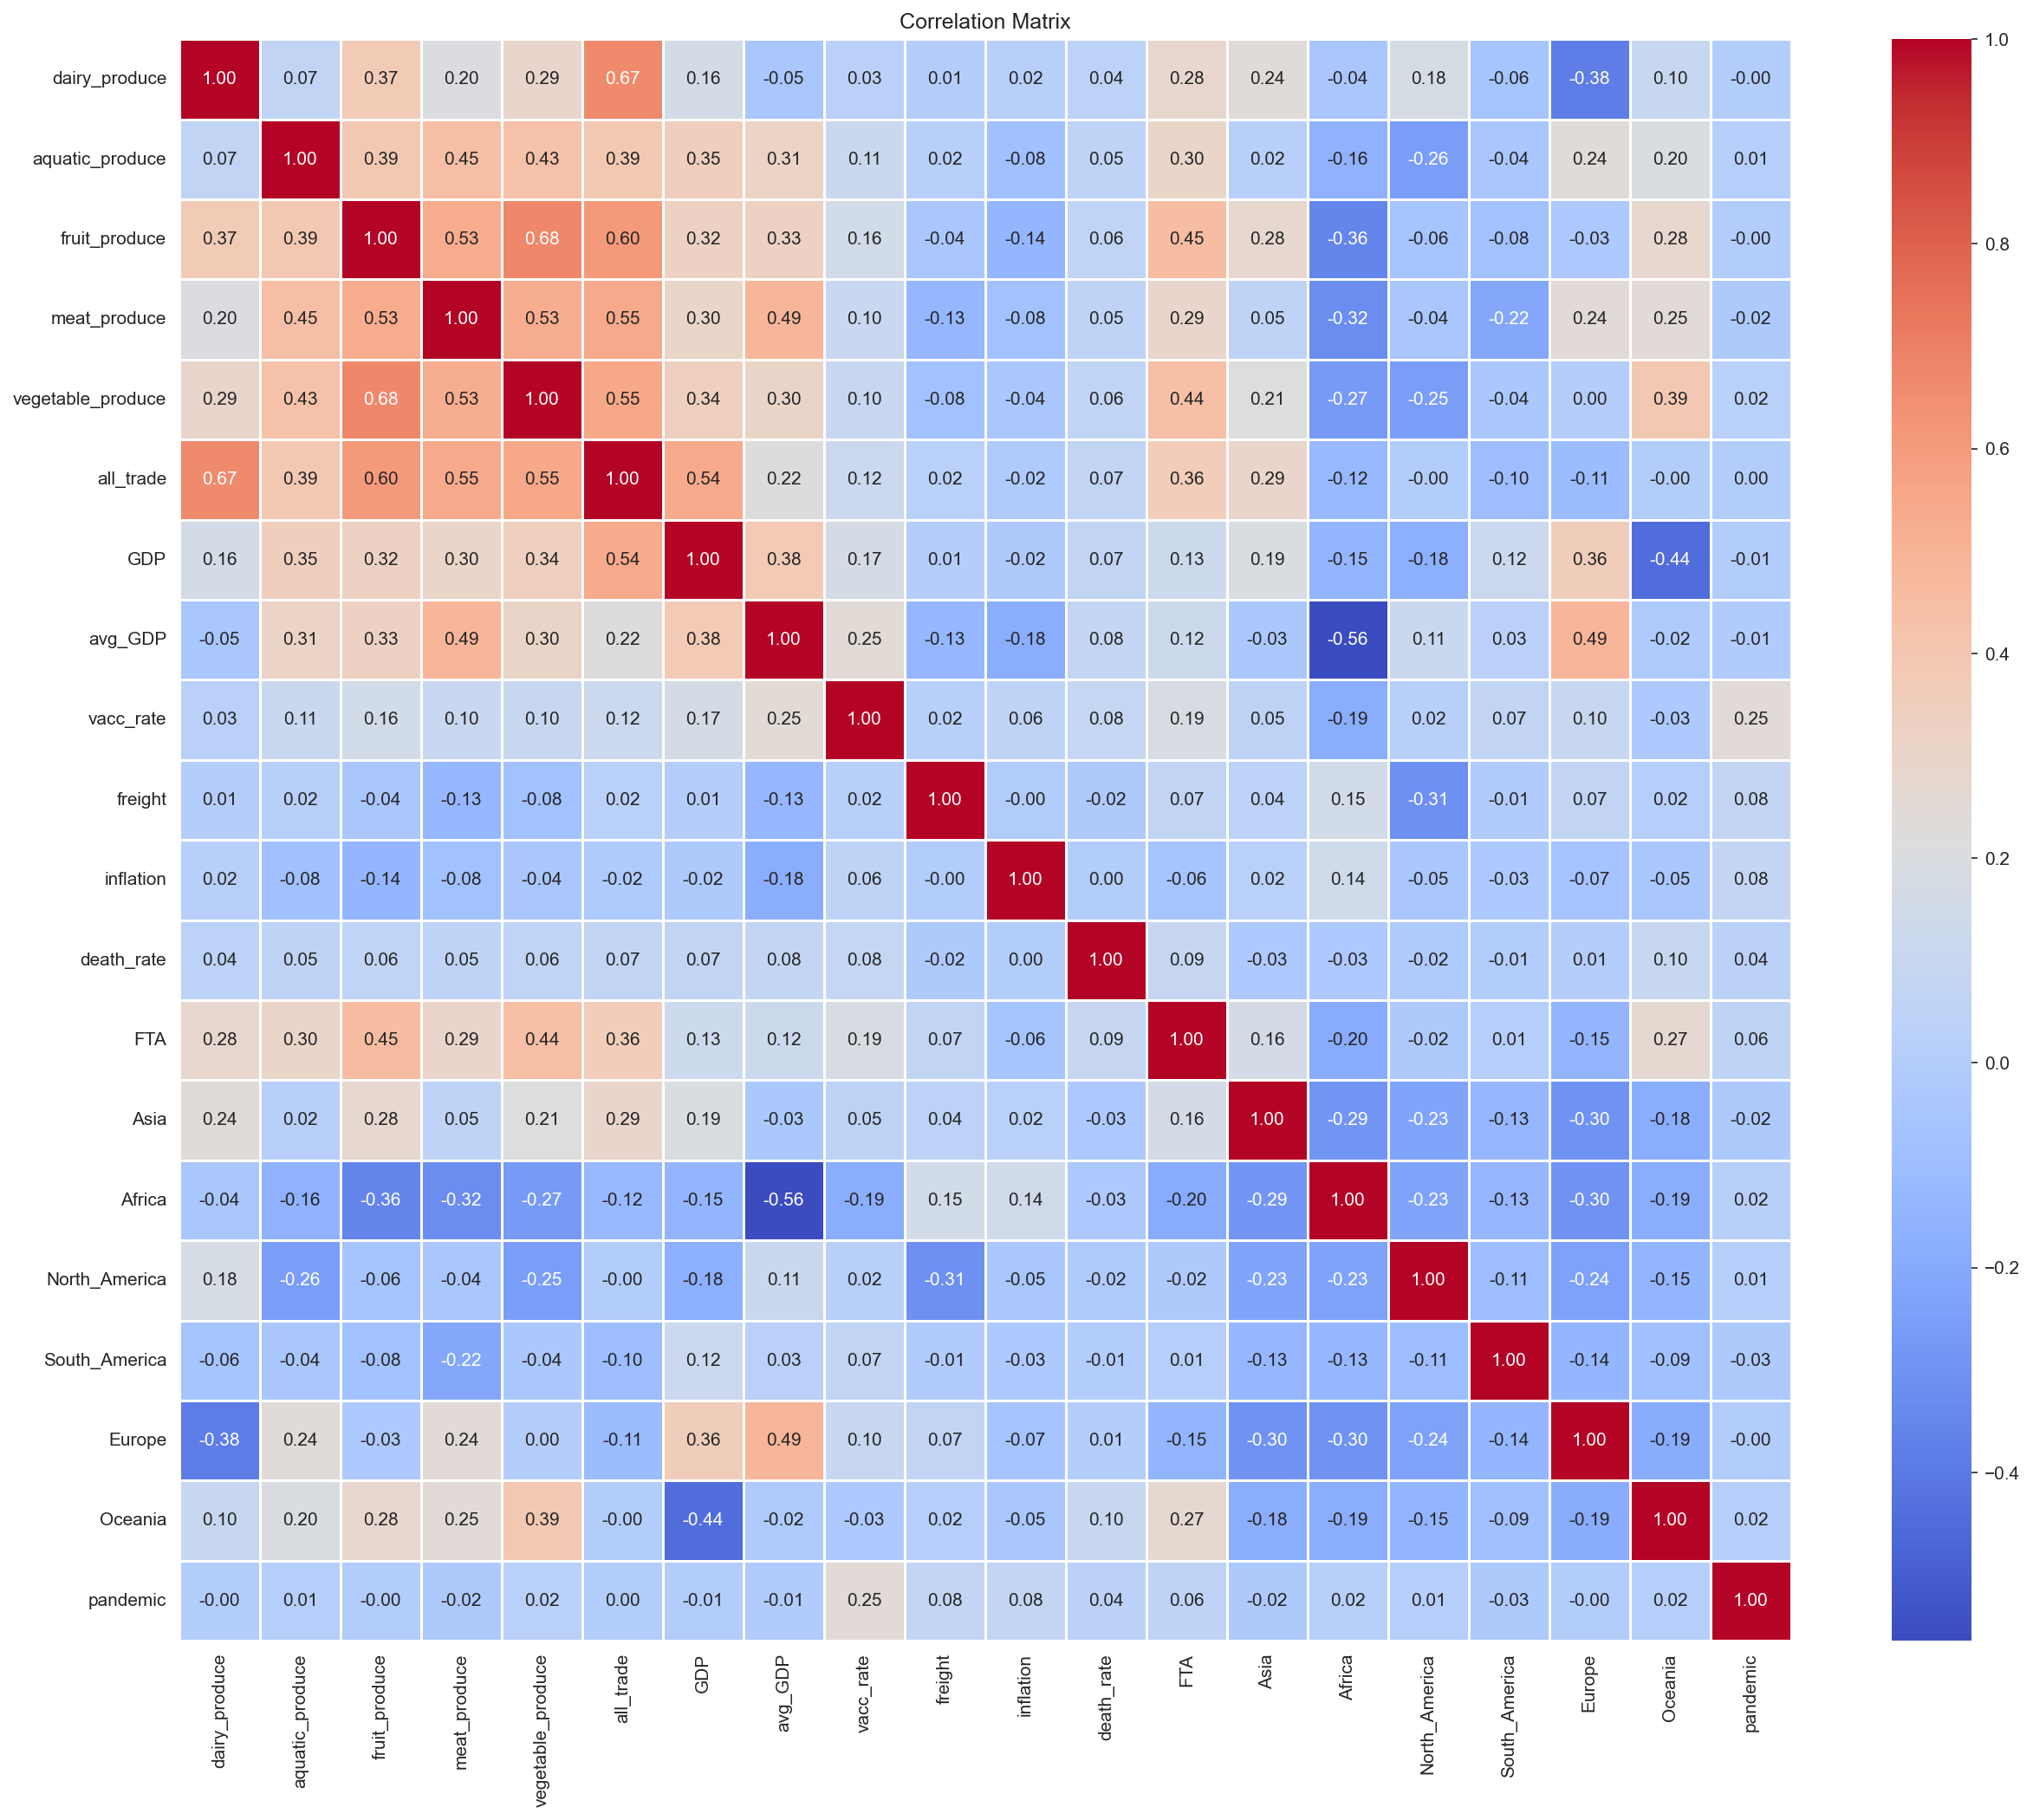

In [17]:
correlation_df = final_data.drop(columns=['year', 'country'])
corr_matrix = correlation_df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Data Distribution

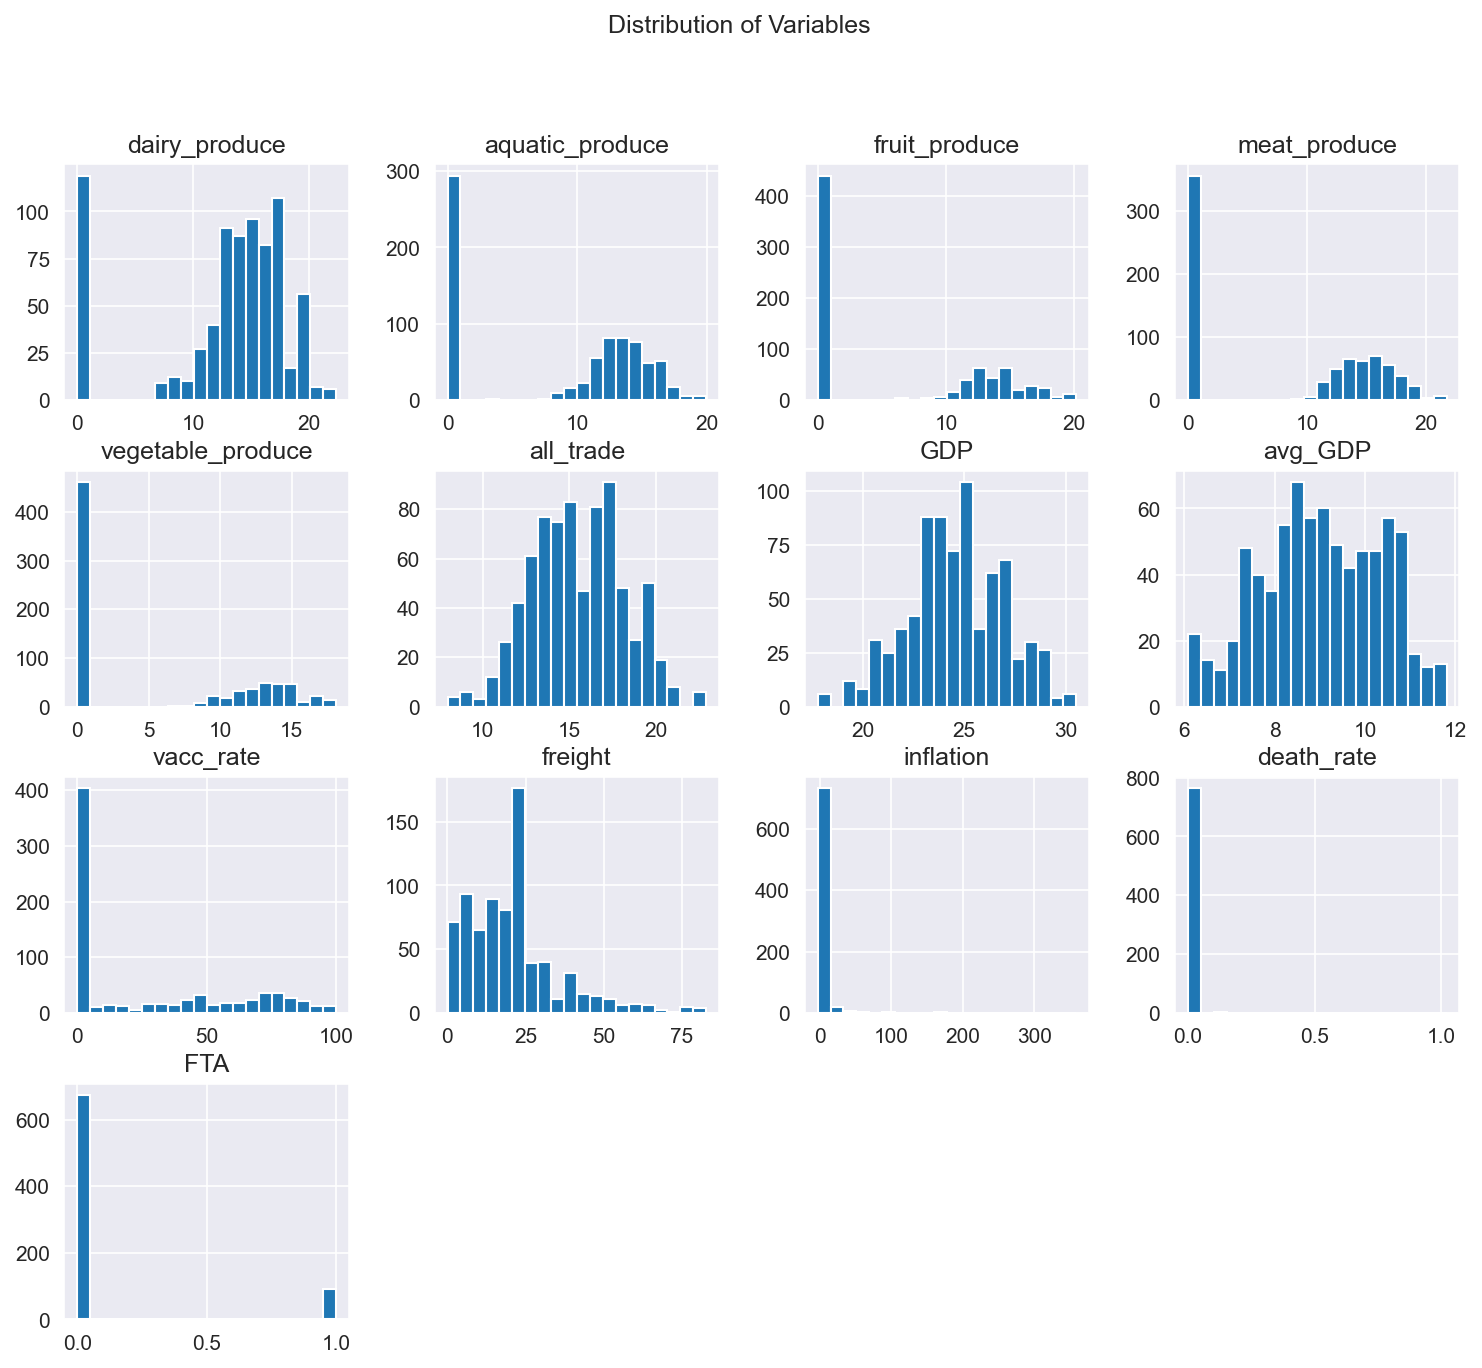

In [18]:
distribution_df = final_data.drop(columns=['year', 'country', 'pandemic', 'Asia', 'Africa', 'North_America', 'South_America', 'Europe', 'Oceania'])
distribution_df.hist(bins=20, figsize=(12, 10))
plt.suptitle('Distribution of Variables')
plt.show()

### Time Series Plot

/var/folders/_t/5xwcj3s913b6rjc1d1nq30m80000gn/T/ipykernel_24219/2896274271.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  final_data.groupby('year').sum().drop(columns=['pandemic', 'FTA', 'Asia', 'Africa', 'North_America', 'South_America', 'Europe', 'Oceania']).plot(subplots=True, figsize=(20, 15), layout=(4, 4), sharex=False)


array([[<AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>,
        <AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>],
       [<AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>,
        <AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>],
       [<AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>,
        <AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>],
       [<AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>,
        <AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>]],
      dtype=object)

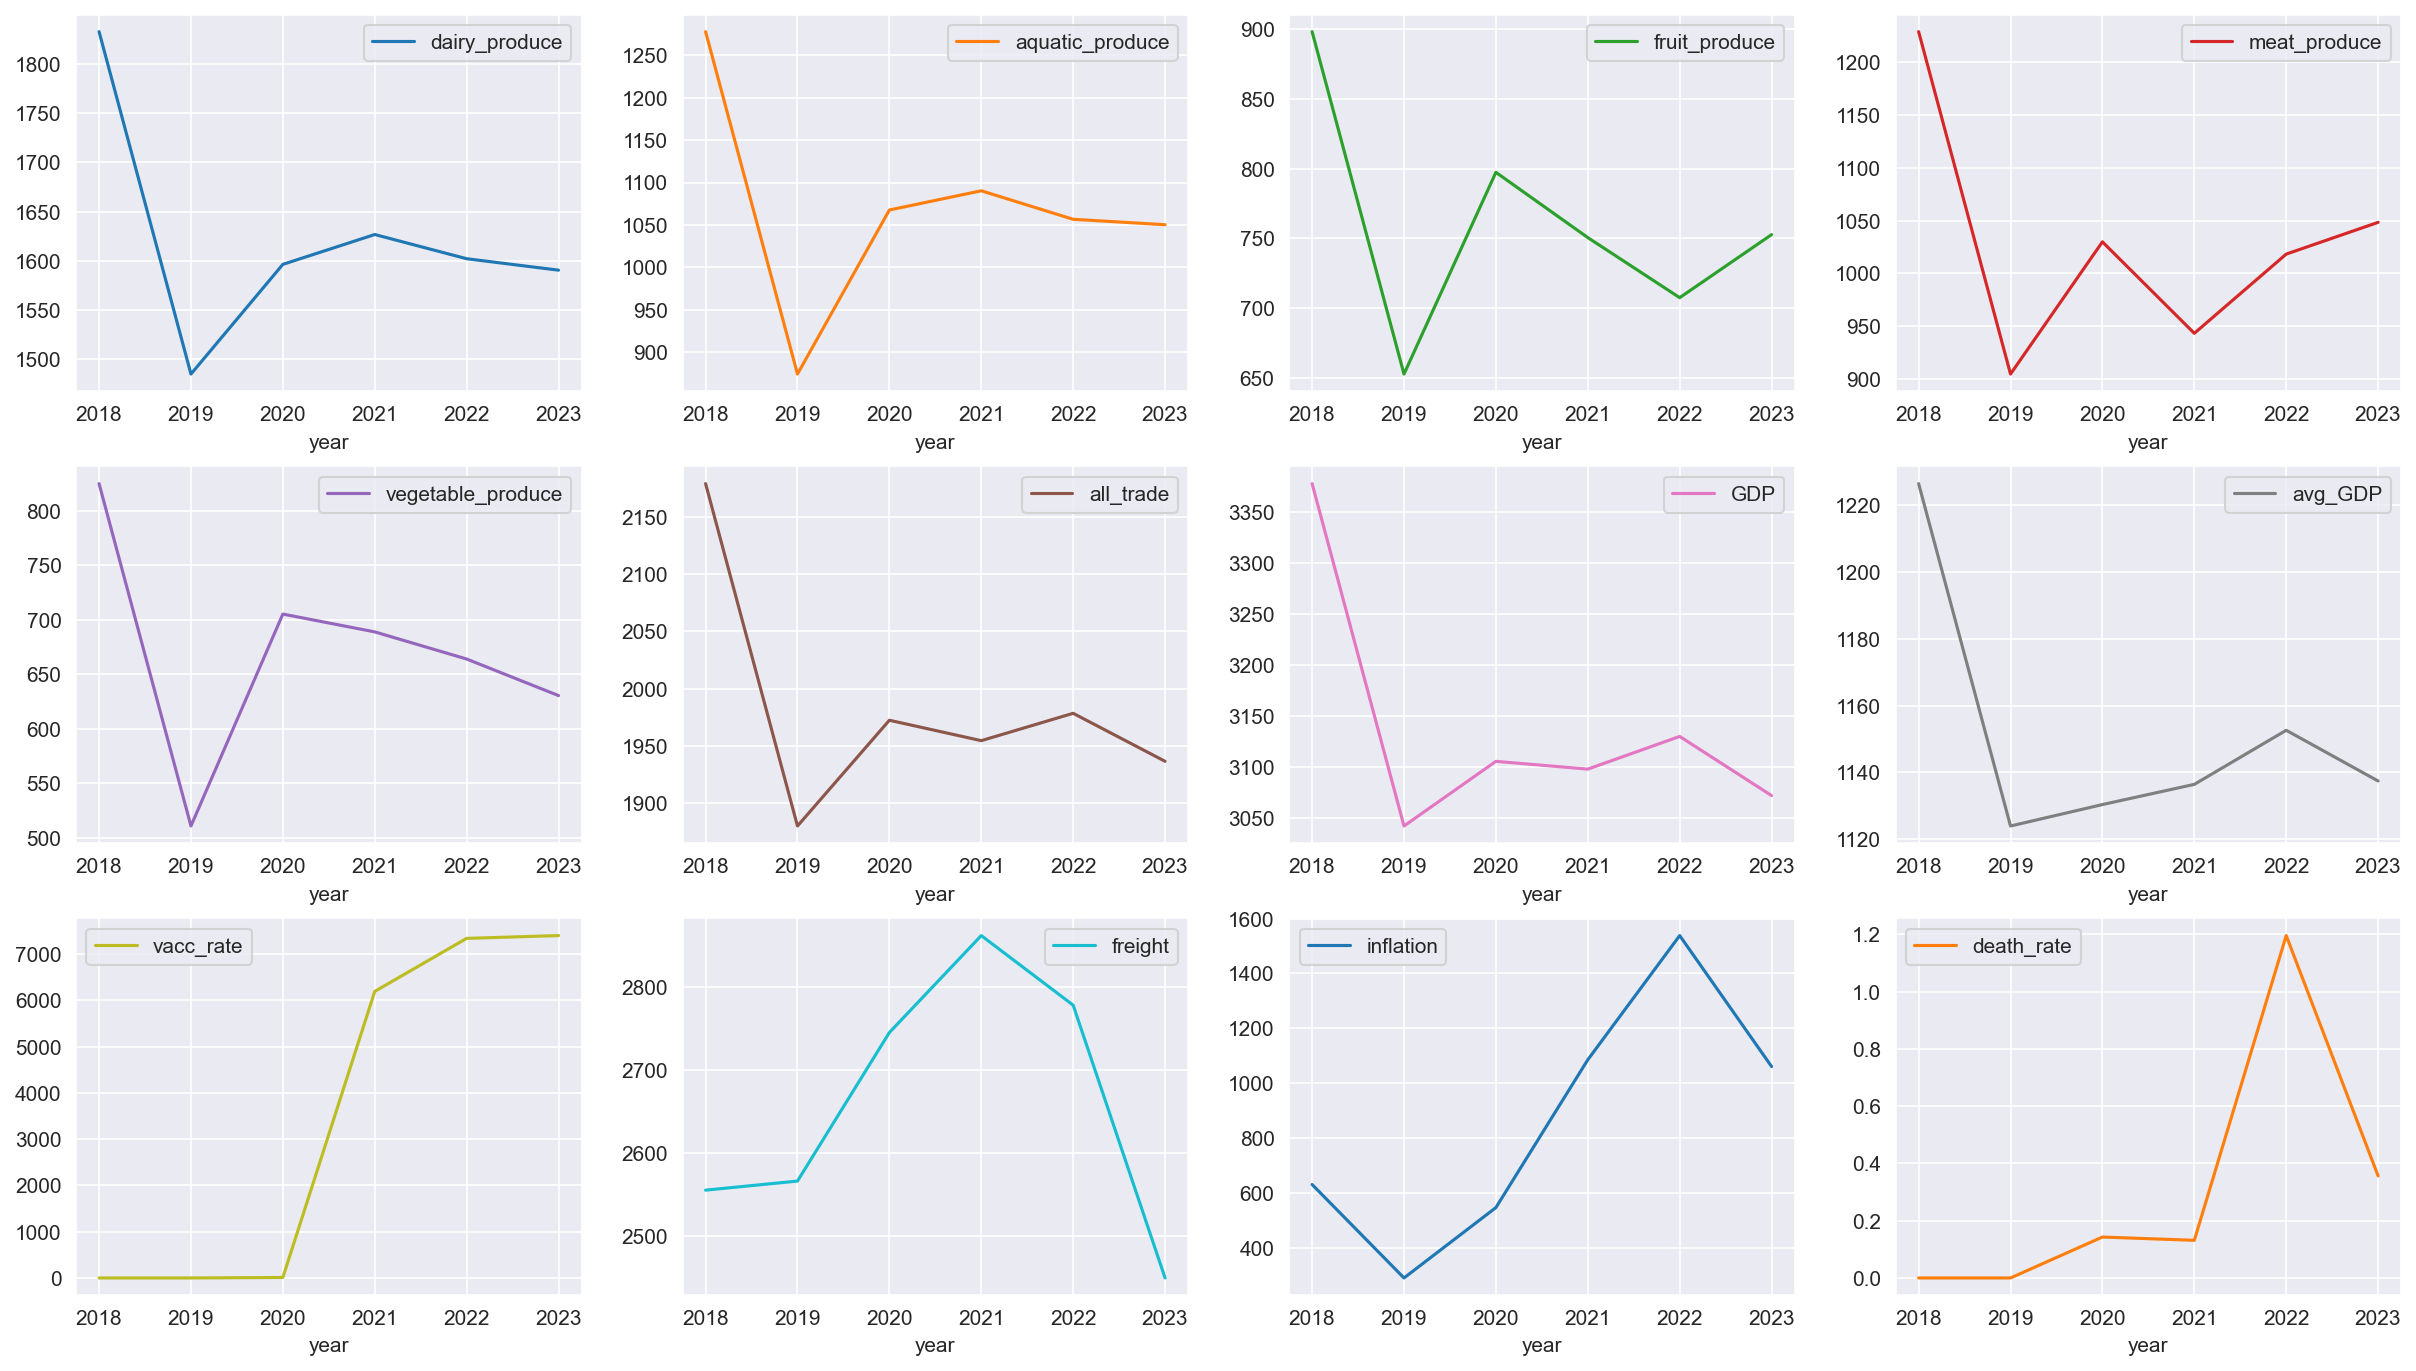

In [19]:
final_data.groupby('year').sum().drop(columns=['pandemic', 'FTA', 'Asia', 'Africa', 'North_America', 'South_America', 'Europe', 'Oceania']).plot(subplots=True, figsize=(20, 15), layout=(4, 4), sharex=False)

### Regression
#### Add polynomial

In [20]:
final_data["pandemic * FTA"] = final_data['pandemic'] * final_data['FTA']
final_data

,year,country,dairy_produce,aquatic_produce,fruit_produce,meat_produce,vegetable_produce,all_trade,GDP,avg_GDP,...,death_rate,FTA,Asia,Africa,North_America,South_America,Europe,Oceania,pandemic,pandemic * FTA
0,2018,Algeria,19.637458,0.000000,0.000000,0.000000,14.672162,19.644409,25.993978,8.442537,...,0.000000,0,0,1,0,0,0,0,0,0
1,2018,Algeria,19.637458,0.000000,0.000000,0.000000,14.672162,19.644409,25.993978,8.442537,...,0.000000,0,0,1,0,0,0,0,0,0
2,2018,American Samoa,13.815398,11.806911,6.652462,14.239359,11.798124,14.843583,20.275415,9.487664,...,0.000000,0,0,0,0,0,0,1,0,0
3,2018,American Samoa,13.815398,11.806911,6.652462,14.239359,11.798124,14.843583,20.275415,9.487664,...,0.000000,0,0,0,0,0,0,1,0,0
4,2018,Angola,15.240254,13.670297,0.000000,0.000000,0.000000,15.429265,25.098402,7.840120,...,0.000000,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,2023,United Rep. of Tanzania,12.845585,0.000000,0.000000,0.000000,0.000000,12.845585,25.094715,7.099250,...,0.000023,0,0,1,0,0,0,0,0,0
762,2023,Uruguay,12.274566,11.264179,0.000000,0.000000,0.000000,12.585044,25.070194,10.024135,...,0.002228,0,0,0,0,1,0,0,0,0
763,2023,Vanuatu,14.872410,13.038237,13.459674,14.483921,14.063850,15.799364,20.842216,8.121806,...,0.000042,1,0,0,0,0,0,1,0,0
764,2023,Yemen,14.457202,0.000000,0.000000,0.000000,0.000000,14.457202,23.770166,6.279210,...,0.000063,0,1,0,0,0,0,0,0,0


#### Multicollinearity analysis

In [21]:
targets = list(all_trade_value.columns)[2:]
targets

['dairy_produce',
 'aquatic_produce',
 'fruit_produce',
 'meat_produce',
 'vegetable_produce',
 'all_trade']

In [22]:
final_data = final_data.dropna()

X_collinear = final_data.drop(columns=['country', 'year']+targets)
X_collinear = sm.add_constant(X_collinear)
vif_data = pd.DataFrame()
vif_data["feature"] = X_collinear.columns
vif_data["VIF"] = [variance_inflation_factor(X_collinear.values, i) for i in range(X_collinear.shape[1])]
vif_data

/Users/wangyaya/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/wangyaya/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,const,0.000000
1,GDP,1.926624
2,avg_GDP,2.123763
3,vacc_rate,1.204187
4,freight,1.155441
5,inflation,1.062610
6,death_rate,1.046145
7,FTA,2.635004
8,Asia,inf
9,Africa,inf


###### All variables has VIF less than 10, so no Multicollinearity problems

## stat OLS (for regression summary)

### Without FTA and COVID

In [23]:
X = final_data.drop(columns=['country', 'year', 'vacc_rate', 'death_rate', 'pandemic', 'pandemic * FTA', 'FTA'] + targets)
y = final_data['dairy_produce']


scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_no_covid_FTA = sm.OLS(y_ols, X_ols).fit()
model_no_covid_FTA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     44.34
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           5.86e-64
Time:                        22:32:47   Log-Likelihood:                -2304.5
No. Observations:                 766   AIC:                             4629.
Df Residuals:                     756   BIC:                             4675.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.7069      0.178     71.277      0.000      12.357      13.057
GDP               2.9031      0.236     12.300      0.000       2.440       3.366
avg_GDP          -0.1513      0.256     -0.592      0.554      -0.653       0.351
freight           0.5936      0.189      3.137      0.002       0.222       0.965
inflation         0.1135      0.182      0.623      0.533      -0.244       0.471
Asia              0.6032      0.146      4.126      0.000       0.316       0.890
Africa           -0.0601      0.176     -0.342      0.733      -0.405       0.285
North_America     1.4718      0.164      8.961      0.000       1.149       1.794
South_America    -0.6761      0.168     -4.021      0.000      -1.006      -0.346
Europe           -2.5973      0.169    -15.324      0.000      -2.930      -2.265
Oceania           1.6497      0.182      9.074      0.000       1.293       2.007
==============================================================================
Omnibus:                      144.204   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.009
Skew:                          -1.231   Prob(JB):                     6.87e-51
Kurtosis:                       4.087   Cond. No.                     2.59e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.56e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Without FTA (Q1)

In [24]:
X = final_data.drop(columns=['country', 'year', 'FTA', 'pandemic * FTA'] + targets)
y = final_data['dairy_produce']


scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_no_FTA = sm.OLS(y_ols, X_ols).fit()
model_no_FTA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     33.19
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           1.28e-61
Time:                        22:32:47   Log-Likelihood:                -2304.3
No. Observations:                 766   AIC:                             4635.
Df Residuals:                     753   BIC:                             4695.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.7069      0.179     71.158      0.000      12.356      13.058
GDP               2.9061      0.238     12.189      0.000       2.438       3.374
avg_GDP          -0.1578      0.260     -0.607      0.544      -0.668       0.352
vacc_rate         0.0401      0.194      0.207      0.836      -0.341       0.421
freight           0.6028      0.191      3.163      0.002       0.229       0.977
inflation         0.1200      0.184      0.653      0.514      -0.241       0.481
death_rate       -0.0258      0.182     -0.142      0.887      -0.383       0.331
Asia              0.5978      0.147      4.070      0.000       0.309       0.886
Africa           -0.0577      0.177     -0.327      0.744      -0.404       0.289
North_America     1.4759      0.165      8.957      0.000       1.152       1.799
South_America    -0.6817      0.169     -4.037      0.000      -1.013      -0.350
Europe           -2.5993      0.170    -15.270      0.000      -2.934      -2.265
Oceania           1.6560      0.184      8.995      0.000       1.295       2.017
pandemic         -0.1243      0.186     -0.668      0.505      -0.490       0.241
==============================================================================
Omnibus:                      143.894   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.363
Skew:                          -1.228   Prob(JB):                     9.49e-51
Kurtosis:                       4.089   Cond. No.                     3.20e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.75e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Without COVID-19 (Q2)

In [25]:
X = final_data.drop(columns=['country', 'year', 'vacc_rate', 'death_rate', 'pandemic', 'pandemic * FTA'] + targets)
y = final_data['dairy_produce']


scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_no_covid = sm.OLS(y_ols, X_ols).fit()
model_no_covid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     40.90
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           1.42e-64
Time:                        22:32:47   Log-Likelihood:                -2301.1
No. Observations:                 766   AIC:                             4624.
Df Residuals:                     755   BIC:                             4675.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.7069      0.178     71.552      0.000      12.358      13.056
GDP               2.7263      0.245     11.146      0.000       2.246       3.206
avg_GDP          -0.1904      0.255     -0.746      0.456      -0.691       0.311
freight           0.5333      0.190      2.808      0.005       0.161       0.906
inflation         0.1248      0.181      0.688      0.492      -0.231       0.481
FTA               0.5284      0.202      2.619      0.009       0.132       0.925
Asia              0.5684      0.146      3.887      0.000       0.281       0.855
Africa           -0.0056      0.176     -0.032      0.975      -0.352       0.341
North_America     1.4475      0.164      8.833      0.000       1.126       1.769
South_America    -0.6589      0.168     -3.931      0.000      -0.988      -0.330
Europe           -2.4666      0.176    -14.009      0.000      -2.812      -2.121
Oceania           1.4573      0.195      7.457      0.000       1.074       1.841
==============================================================================
Omnibus:                      138.342   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.475
Skew:                          -1.206   Prob(JB):                     9.84e-48
Kurtosis:                       3.983   Cond. No.                     2.24e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.42e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Dairy produce

In [26]:
X = final_data.drop(columns=['country', 'year'] + targets)
y = final_data['dairy_produce']


scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_diary = sm.OLS(y_ols, X_ols).fit()
model_diary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     29.14
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           1.42e-61
Time:                        22:32:47   Log-Likelihood:                -2300.7
No. Observations:                 766   AIC:                             4631.
Df Residuals:                     751   BIC:                             4701.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             12.7069      0.178     71.396      0.000      12.358      13.056
GDP                2.7345      0.247     11.069      0.000       2.250       3.219
avg_GDP           -0.1797      0.259     -0.693      0.489      -0.689       0.329
vacc_rate         -0.0346      0.195     -0.177      0.859      -0.418       0.349
freight            0.5457      0.191      2.852      0.004       0.170       0.921
inflation          0.1410      0.183      0.768      0.443      -0.219       0.501
death_rate        -0.0400      0.182     -0.220      0.826      -0.397       0.317
FTA                0.5300      0.289      1.835      0.067      -0.037       1.097
Asia               0.5633      0.147      3.833      0.000       0.275       0.852
Africa            -0.0051      0.177     -0.029      0.977      -0.353       0.343
North_America      1.4537      0.164      8.838      0.000       1.131       1.777
South_America     -0.6610      0.168     -3.923      0.000      -0.992      -0.330
Europe            -2.4686      0.177    -13.959      0.000      -2.816      -2.121
Oceania            1.4608      0.198      7.387      0.000       1.073       1.849
pandemic          -0.1351      0.197     -0.687      0.492      -0.521       0.251
pandemic * FTA     0.0188      0.283      0.066      0.947      -0.538       0.575
==============================================================================
Omnibus:                      137.823   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              215.331
Skew:                          -1.203   Prob(JB):                     1.74e-47
Kurtosis:                       3.981   Cond. No.                     2.56e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.85e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Hypothesis test check whether linear regression works (Diary Produce)
##### 1 & 3. Linearity and  Homoscedasticity (residual plot)

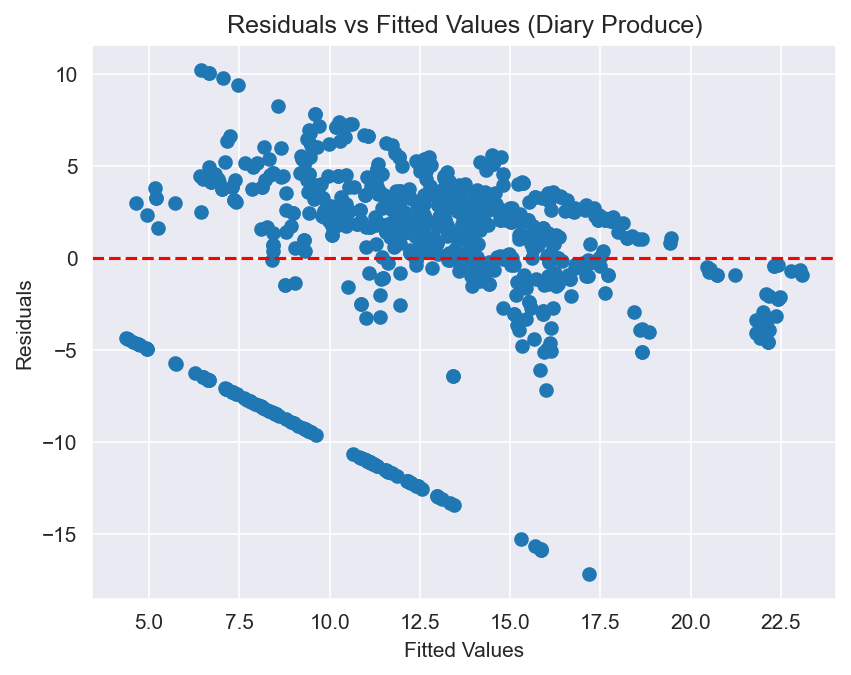

In [27]:
# feature = ['GDP', 'vacc_rate', 'freight', 'inflation', 'death_rate']
# target = 'dairy_produce'
# scatter_plot = sns.pairplot(final_data, x_vars=feature, y_vars=target, kind='scatter')
# scatter_plot.fig.set_size_inches(30, 6)
# plt.show()

plt.scatter(model_diary.fittedvalues, model_diary.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Diary Produce)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

##### 2. Normality of Errors (Histogram of Residuals and Q-Q plot)

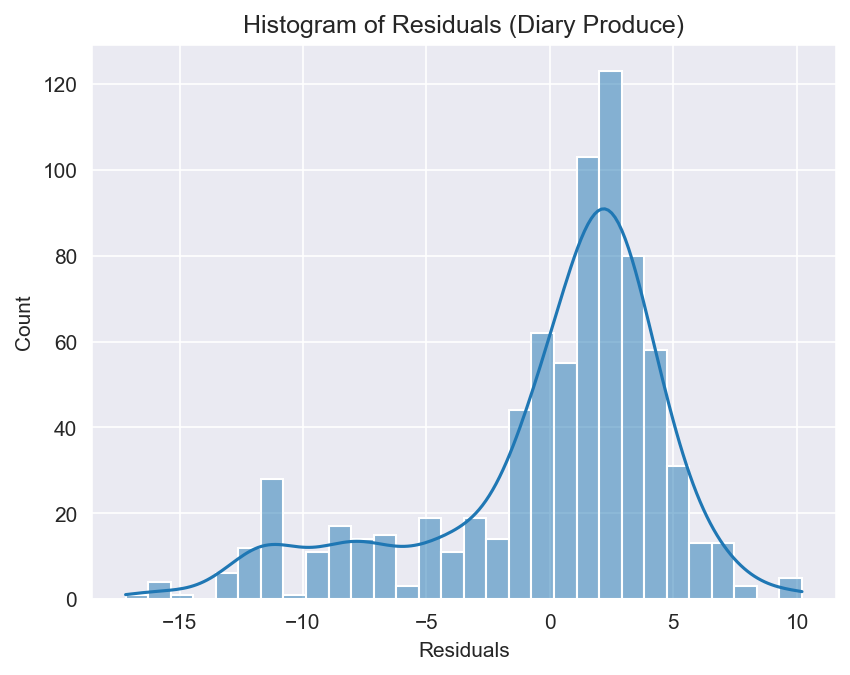

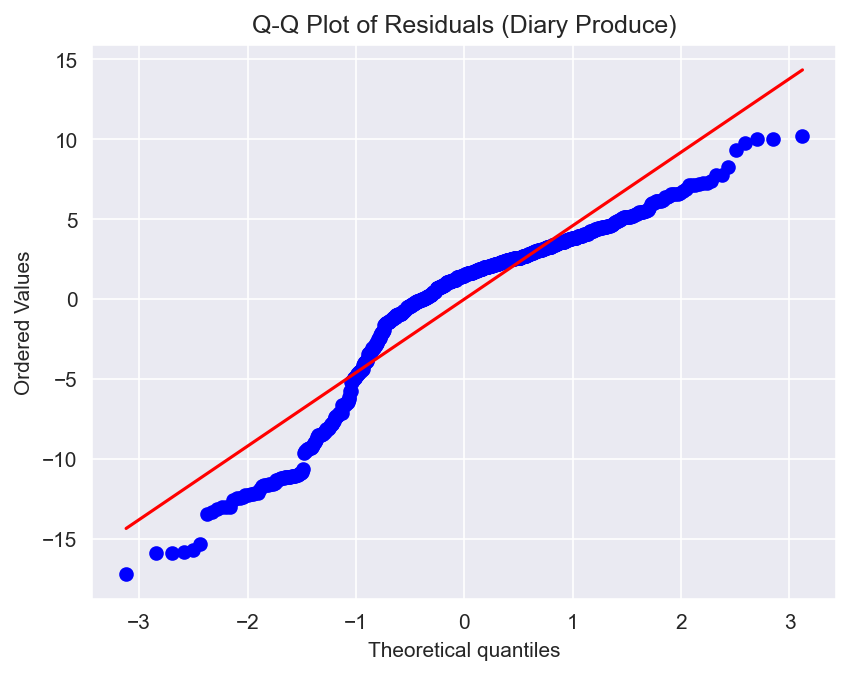

In [28]:
# standard residuals
sns.histplot(model_diary.resid, kde=True)
plt.title('Histogram of Residuals (Diary Produce)')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot
stats.probplot(model_diary.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Diary Produce)')
plt.show()

### Aquatic produce

In [29]:
y = final_data['aquatic_produce']
scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_aquatic = sm.OLS(y_ols, X_ols).fit()
model_aquatic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     28.26
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           6.91e-60
Time:                        22:32:48   Log-Likelihood:                -2399.5
No. Observations:                 766   AIC:                             4829.
Df Residuals:                     751   BIC:                             4899.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.3774      0.202     41.373      0.000       7.980       8.775
GDP                2.5167      0.281      8.955      0.000       1.965       3.068
avg_GDP            1.1531      0.295      3.908      0.000       0.574       1.732
vacc_rate         -0.0073      0.222     -0.033      0.974      -0.444       0.429
freight           -0.3113      0.218     -1.430      0.153      -0.739       0.116
inflation         -0.2346      0.209     -1.124      0.261      -0.644       0.175
death_rate        -0.2512      0.207     -1.213      0.225      -0.658       0.155
FTA                1.1988      0.329      3.647      0.000       0.554       1.844
Asia              -0.3966      0.167     -2.372      0.018      -0.725      -0.068
Africa             0.1778      0.202      0.882      0.378      -0.218       0.574
North_America     -1.3149      0.187     -7.027      0.000      -1.682      -0.948
South_America     -0.6128      0.192     -3.197      0.001      -0.989      -0.237
Europe             0.2530      0.201      1.258      0.209      -0.142       0.648
Oceania            1.9519      0.225      8.676      0.000       1.510       2.394
pandemic           0.0678      0.224      0.303      0.762      -0.371       0.507
pandemic * FTA    -0.0060      0.322     -0.019      0.985      -0.639       0.627
==============================================================================
Omnibus:                       64.412   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.420
Skew:                          -0.284   Prob(JB):                     4.09e-07
Kurtosis:                       2.226   Cond. No.                     2.56e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.85e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Hypothesis test check whether linear regression works (Diary Produce)
##### 1. Linearity and  Homoscedasticity (residual plot)

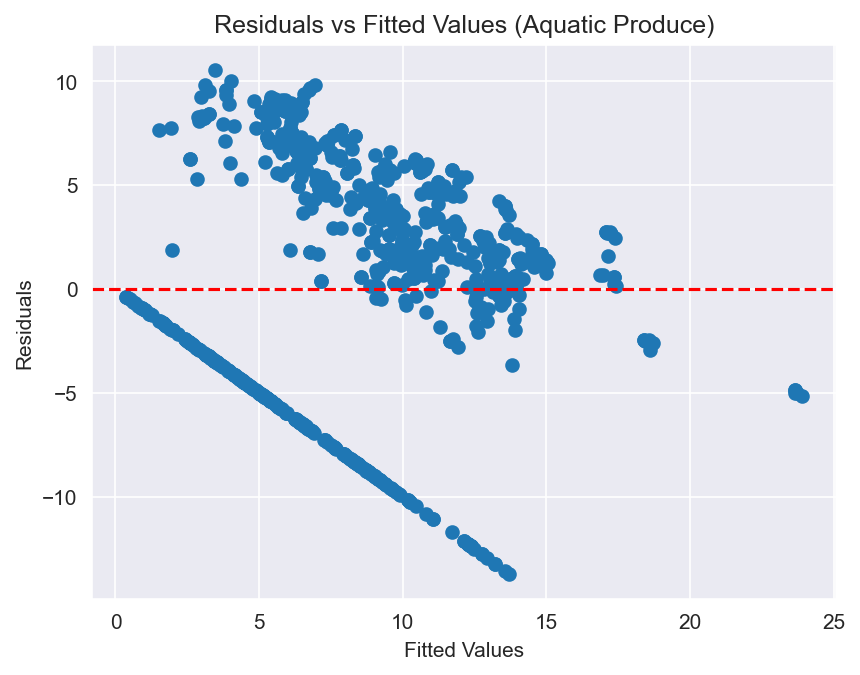

In [30]:
plt.scatter(model_aquatic.fittedvalues, model_aquatic.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Aquatic Produce)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

##### 2. Normality of Errors (Histogram of Residuals and Q-Q plot)

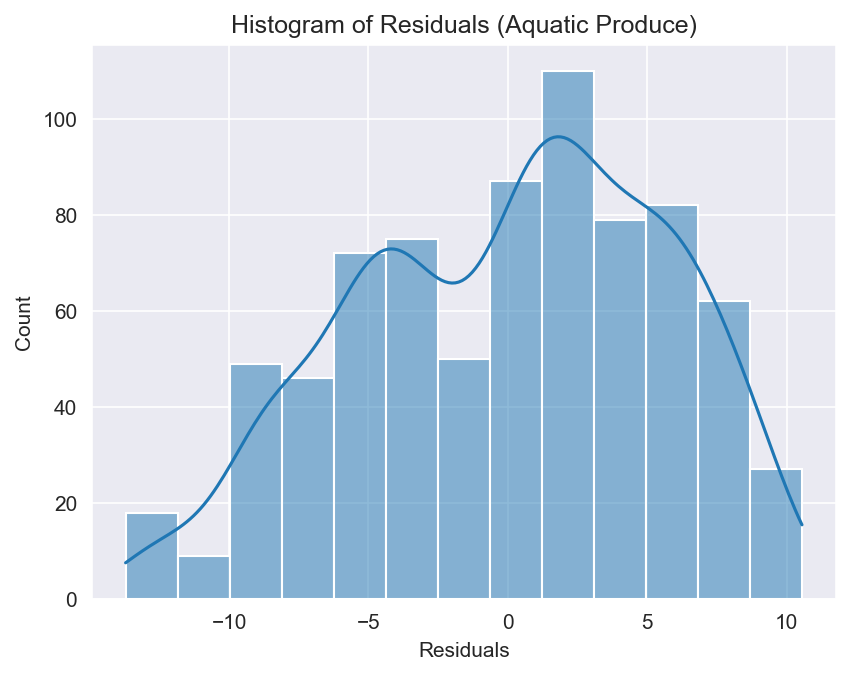

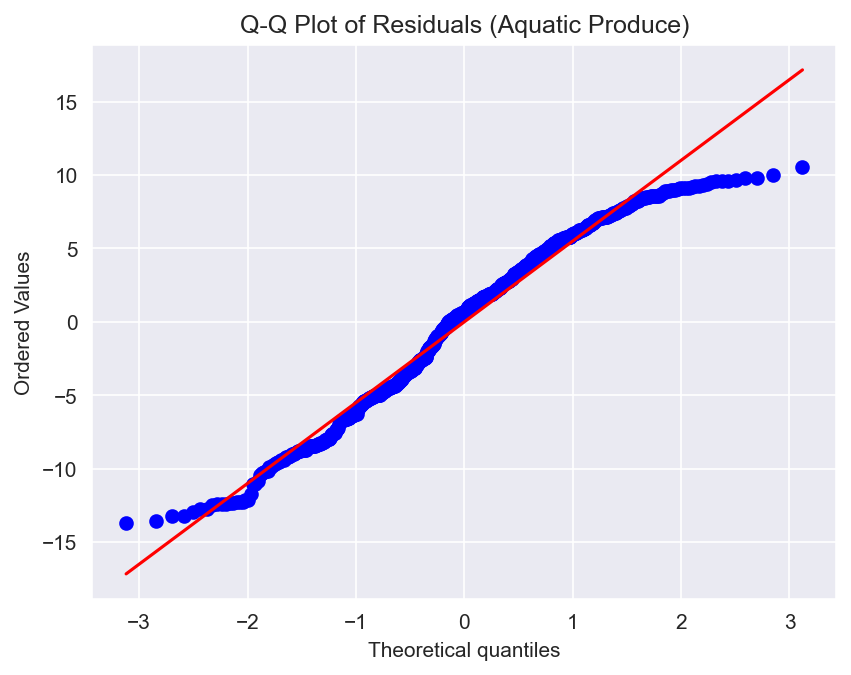

In [31]:
# standard residuals
sns.histplot(model_aquatic.resid, kde=True)
plt.title('Histogram of Residuals (Aquatic Produce)')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot
stats.probplot(model_aquatic.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Aquatic Produce)')
plt.show()

### Fruit produce

In [32]:
y = final_data['fruit_produce']
scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_fruit = sm.OLS(y_ols, X_ols).fit()
model_fruit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     53.43
Date:                Sat, 31 Aug 2024   Prob (F-statistic):          1.23e-102
Time:                        22:32:49   Log-Likelihood:                -2323.4
No. Observations:                 766   AIC:                             4677.
Df Residuals:                     751   BIC:                             4746.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.9524      0.183     32.467      0.000       5.593       6.312
GDP                3.1359      0.254     12.323      0.000       2.636       3.635
avg_GDP            1.1298      0.267      4.229      0.000       0.605       1.654
vacc_rate          0.1704      0.201      0.847      0.397      -0.225       0.565
freight           -0.1706      0.197     -0.866      0.387      -0.557       0.216
inflation         -0.5255      0.189     -2.780      0.006      -0.896      -0.154
death_rate        -0.2906      0.188     -1.550      0.122      -0.659       0.078
FTA                1.4625      0.298      4.914      0.000       0.878       2.047
Asia               0.8702      0.151      5.748      0.000       0.573       1.167
Africa            -0.8362      0.183     -4.580      0.000      -1.195      -0.478
North_America     -0.1023      0.169     -0.604      0.546      -0.435       0.230
South_America     -0.9705      0.174     -5.592      0.000      -1.311      -0.630
Europe            -1.3421      0.182     -7.367      0.000      -1.700      -0.984
Oceania            2.6746      0.204     13.129      0.000       2.275       3.074
pandemic          -0.0679      0.203     -0.335      0.738      -0.466       0.330
pandemic * FTA    -0.0283      0.292     -0.097      0.923      -0.601       0.545
==============================================================================
Omnibus:                       29.416   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.649
Skew:                           0.221   Prob(JB):                     0.000147
Kurtosis:                       2.402   Cond. No.                     2.56e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.85e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Hypothesis test check whether linear regression works (Fruit Produce)
##### 1. Linearity and  Homoscedasticity (residual plot)

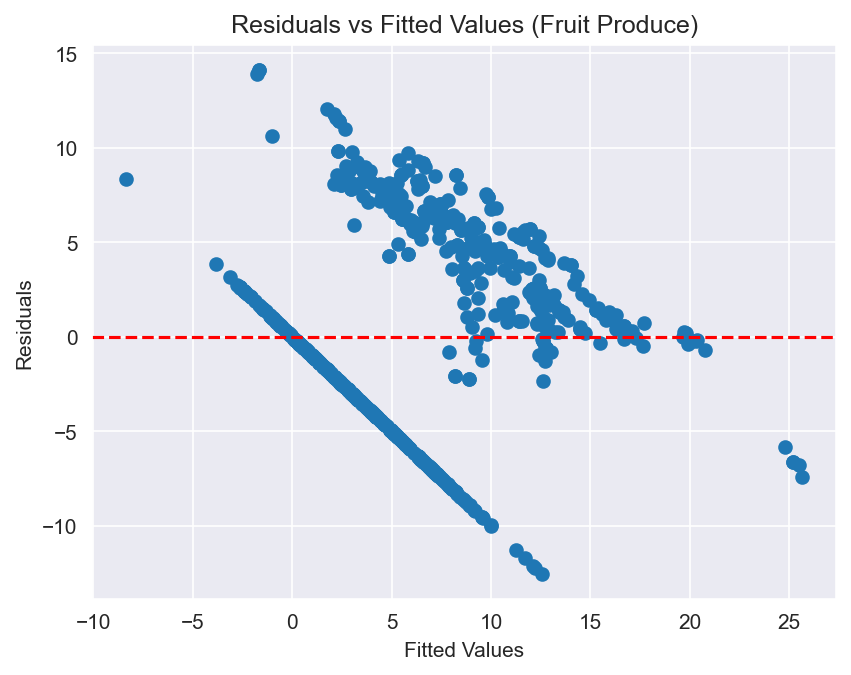

In [33]:
plt.scatter(model_fruit.fittedvalues, model_fruit.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Fruit Produce)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

##### 2. Normality of Errors (Histogram of Residuals and Q-Q plot)

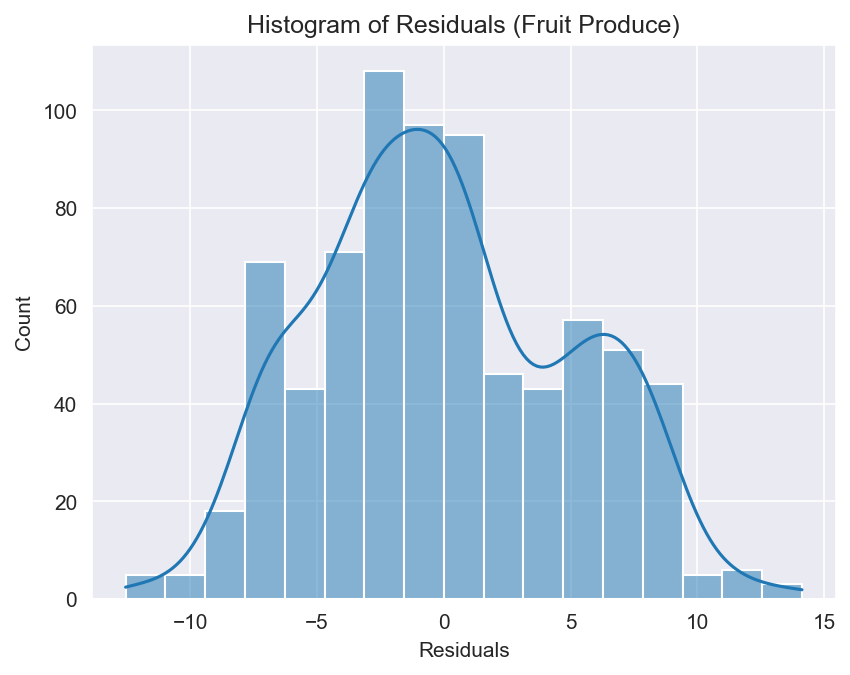

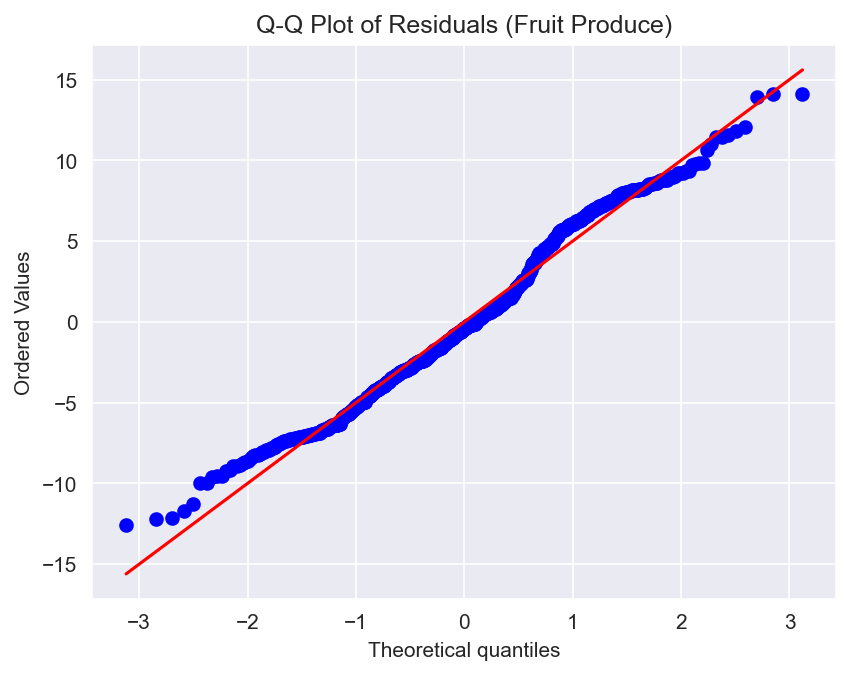

In [34]:
# standard residuals
sns.histplot(model_fruit.resid, kde=True)
plt.title('Histogram of Residuals (Fruit Produce)')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot
stats.probplot(model_fruit.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Fruit Produce)')
plt.show()

### Meat Produce

In [35]:
y = final_data['meat_produce']
scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_meat = sm.OLS(y_ols, X_ols).fit()
model_meat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     46.55
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           5.52e-92
Time:                        22:32:49   Log-Likelihood:                -2412.1
No. Observations:                 766   AIC:                             4854.
Df Residuals:                     751   BIC:                             4924.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.0595      0.206     39.157      0.000       7.655       8.464
GDP                2.5066      0.286      8.774      0.000       1.946       3.067
avg_GDP            2.7769      0.300      9.258      0.000       2.188       3.366
vacc_rate         -0.2722      0.226     -1.205      0.229      -0.716       0.171
freight           -0.9075      0.221     -4.102      0.000      -1.342      -0.473
inflation          0.1427      0.212      0.673      0.501      -0.274       0.559
death_rate        -0.3784      0.211     -1.798      0.073      -0.792       0.035
FTA                0.6979      0.334      2.089      0.037       0.042       1.354
Asia              -0.0936      0.170     -0.551      0.582      -0.427       0.240
Africa            -0.2280      0.205     -1.113      0.266      -0.630       0.174
North_America     -0.3877      0.190     -2.038      0.042      -0.761      -0.014
South_America     -1.9257      0.195     -9.883      0.000      -2.308      -1.543
Europe            -0.0954      0.205     -0.467      0.641      -0.497       0.306
Oceania            2.4938      0.229     10.905      0.000       2.045       2.943
pandemic          -0.2394      0.227     -1.053      0.293      -0.686       0.207
pandemic * FTA     0.4967      0.328      1.515      0.130      -0.147       1.140
==============================================================================
Omnibus:                       20.670   Durbin-Watson:                   1.597
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.314
Skew:                          -0.146   Prob(JB):                      0.00212
Kurtosis:                       2.451   Cond. No.                     2.56e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.85e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Hypothesis test check whether linear regression works (Meat Produce)
##### 1. Linearity and  Homoscedasticity (residual plot)

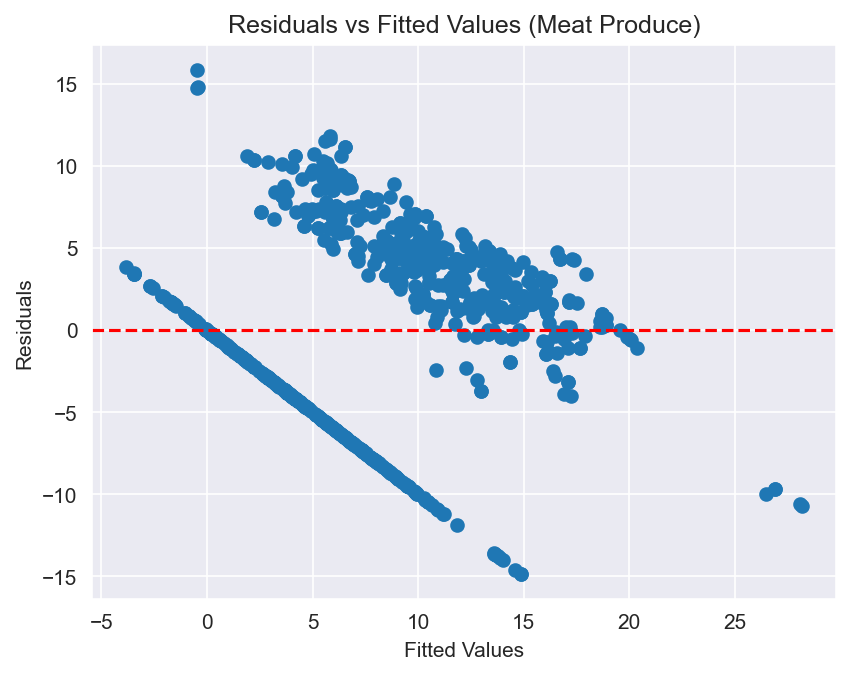

In [36]:
plt.scatter(model_meat.fittedvalues, model_meat.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Meat Produce)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

##### 2. Normality of Errors (Histogram of Residuals and Q-Q plot)

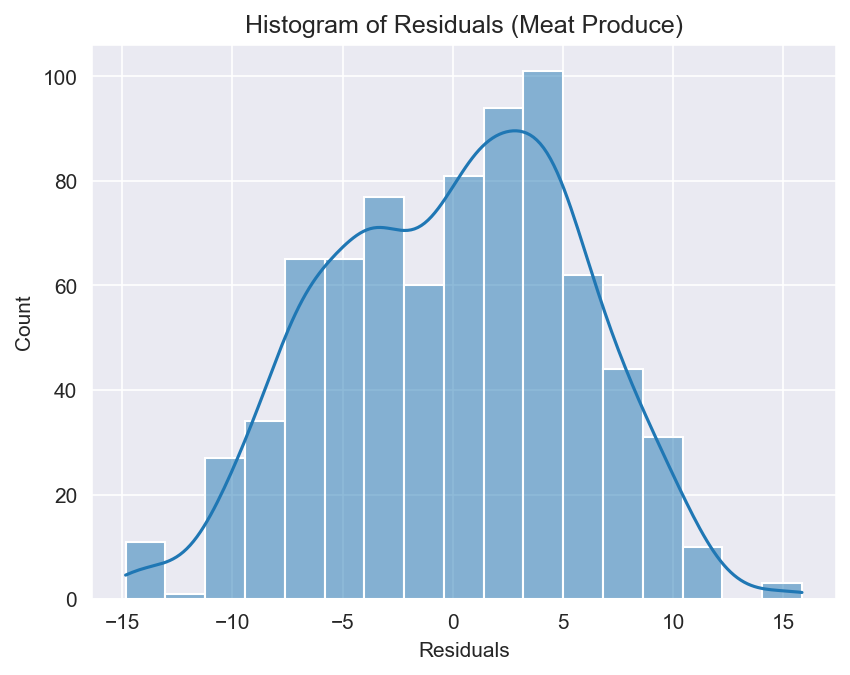

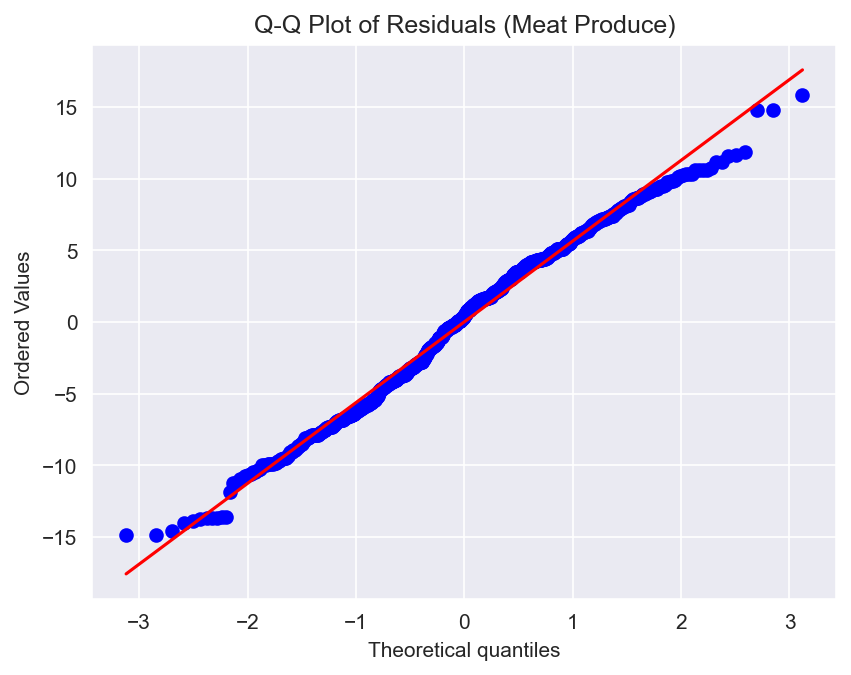

In [37]:
# standard residuals
sns.histplot(model_meat.resid, kde=True)
plt.title('Histogram of Residuals (Meat Produce)')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot
stats.probplot(model_meat.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Meat Produce)')
plt.show()

### Vegetable Produce

In [38]:
y = final_data['vegetable_produce']
scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_vegetable = sm.OLS(y_ols, X_ols).fit()
model_vegetable.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     79.33
Date:                Sat, 31 Aug 2024   Prob (F-statistic):          1.69e-137
Time:                        22:32:50   Log-Likelihood:                -2188.9
No. Observations:                 766   AIC:                             4408.
Df Residuals:                     751   BIC:                             4477.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.2539      0.154     34.161      0.000       4.952       5.556
GDP                3.3889      0.213     15.874      0.000       2.970       3.808
avg_GDP            1.2860      0.224      5.738      0.000       0.846       1.726
vacc_rate         -0.2471      0.169     -1.464      0.144      -0.578       0.084
freight           -0.8361      0.165     -5.058      0.000      -1.161      -0.512
inflation          0.1114      0.159      0.703      0.482      -0.200       0.423
death_rate        -0.4261      0.157     -2.709      0.007      -0.735      -0.117
FTA                1.1402      0.250      4.567      0.000       0.650       1.630
Asia               0.4530      0.127      3.566      0.000       0.204       0.702
Africa            -0.2490      0.153     -1.626      0.104      -0.550       0.052
North_America     -1.2802      0.142     -9.007      0.000      -1.559      -1.001
South_America     -0.6637      0.146     -4.559      0.000      -0.950      -0.378
Europe            -1.2193      0.153     -7.978      0.000      -1.519      -0.919
Oceania            3.4153      0.171     19.985      0.000       3.080       3.751
pandemic           0.1974      0.170      1.162      0.246      -0.136       0.531
pandemic * FTA     0.1276      0.245      0.521      0.602      -0.353       0.608
==============================================================================
Omnibus:                        0.735   Durbin-Watson:                   1.485
Prob(Omnibus):                  0.692   Jarque-Bera (JB):                0.826
Skew:                           0.059   Prob(JB):                        0.662
Kurtosis:                       2.891   Cond. No.                     2.56e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.85e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Hypothesis test check whether linear regression works (Vegetable Produce)
##### 1. Linearity and  Homoscedasticity (residual plot)

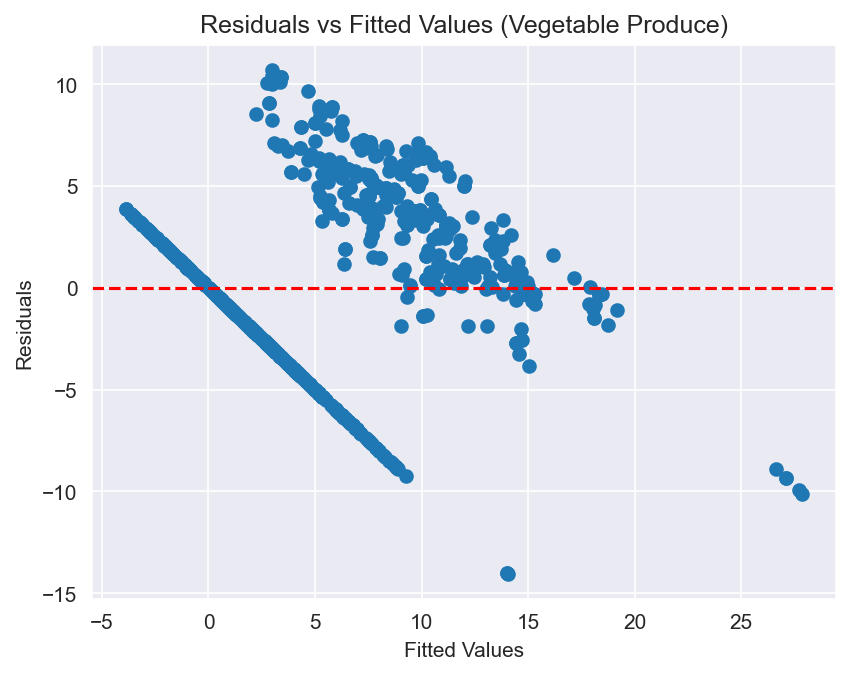

In [39]:
plt.scatter(model_vegetable.fittedvalues, model_vegetable.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Vegetable Produce)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

##### 2. Normality of Errors (Histogram of Residuals and Q-Q plot)

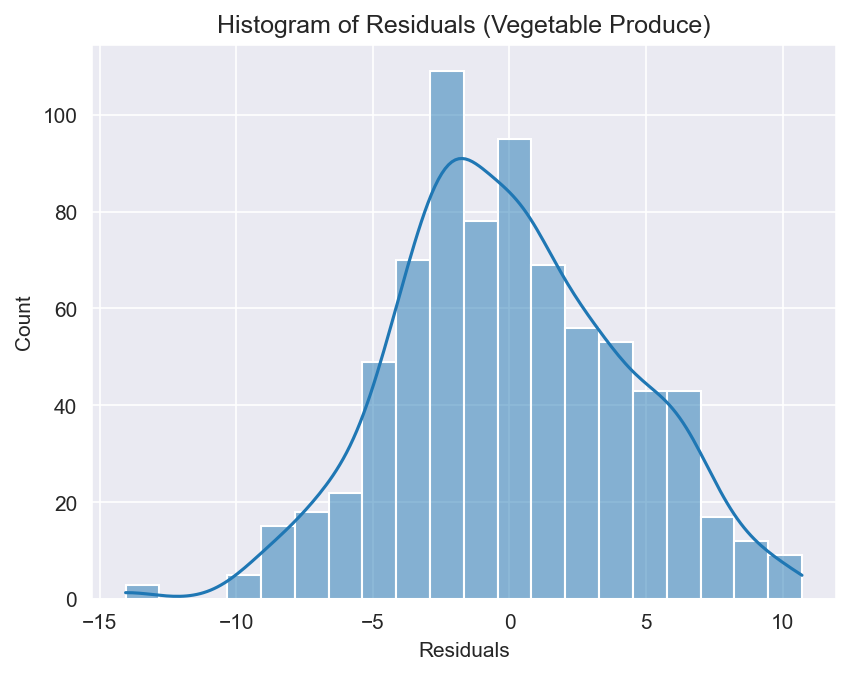

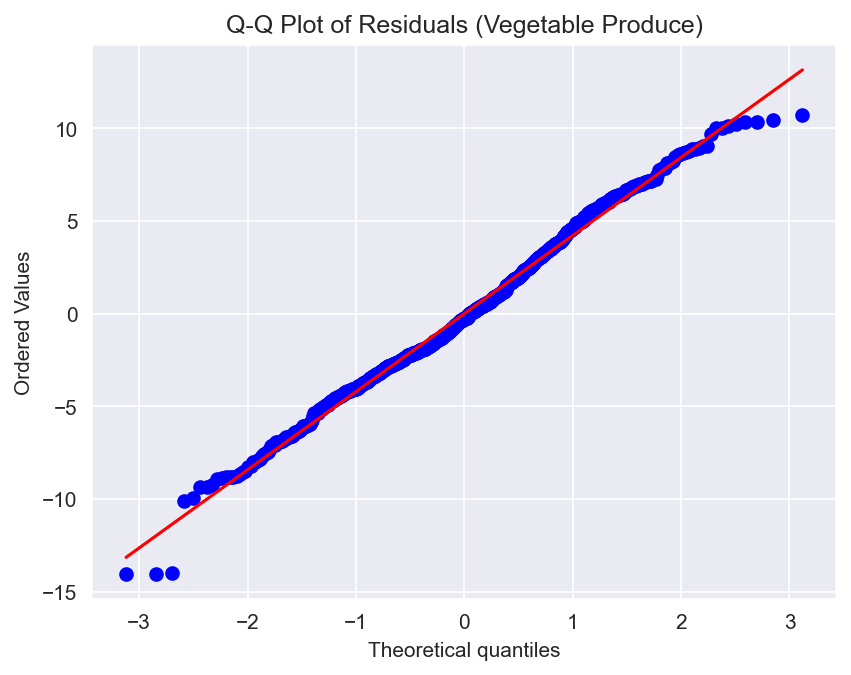

In [40]:
# standard residuals
sns.histplot(model_vegetable.resid, kde=True)
plt.title('Histogram of Residuals (Vegetable Produce)')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot
stats.probplot(model_vegetable.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Vegetable Produce)')
plt.show()

### All trade

In [41]:
y = final_data['all_trade']
scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_all = sm.OLS(y_ols, X_ols).fit()
model_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     63.70
Date:                Sat, 31 Aug 2024   Prob (F-statistic):          2.42e-117
Time:                        22:32:51   Log-Likelihood:                -1530.5
No. Observations:                 766   AIC:                             3091.
Df Residuals:                     751   BIC:                             3161.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             15.5374      0.065    238.620      0.000      15.410      15.665
GDP                1.9385      0.090     21.448      0.000       1.761       2.116
avg_GDP            0.3344      0.095      3.524      0.000       0.148       0.521
vacc_rate         -0.0225      0.071     -0.315      0.753      -0.163       0.118
freight            0.1717      0.070      2.453      0.014       0.034       0.309
inflation          0.0403      0.067      0.600      0.549      -0.091       0.172
death_rate        -0.0629      0.067     -0.944      0.345      -0.194       0.068
FTA                0.3135      0.106      2.966      0.003       0.106       0.521
Asia               0.2498      0.054      4.645      0.000       0.144       0.355
Africa             0.1277      0.065      1.969      0.049       0.000       0.255
North_America      0.2985      0.060      4.961      0.000       0.180       0.417
South_America     -0.4796      0.062     -7.780      0.000      -0.601      -0.359
Europe            -0.8494      0.065    -13.128      0.000      -0.976      -0.722
Oceania            0.6801      0.072      9.401      0.000       0.538       0.822
pandemic          -0.0485      0.072     -0.674      0.501      -0.190       0.093
pandemic * FTA     0.0537      0.104      0.517      0.605      -0.150       0.257
==============================================================================
Omnibus:                       75.481   Durbin-Watson:                   1.709
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.427
Skew:                          -0.710   Prob(JB):                     3.86e-25
Kurtosis:                       4.228   Cond. No.                     2.56e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.85e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Hypothesis test check whether linear regression works (Fruit Produce)
##### 1. Linearity and  Homoscedasticity (residual plot)

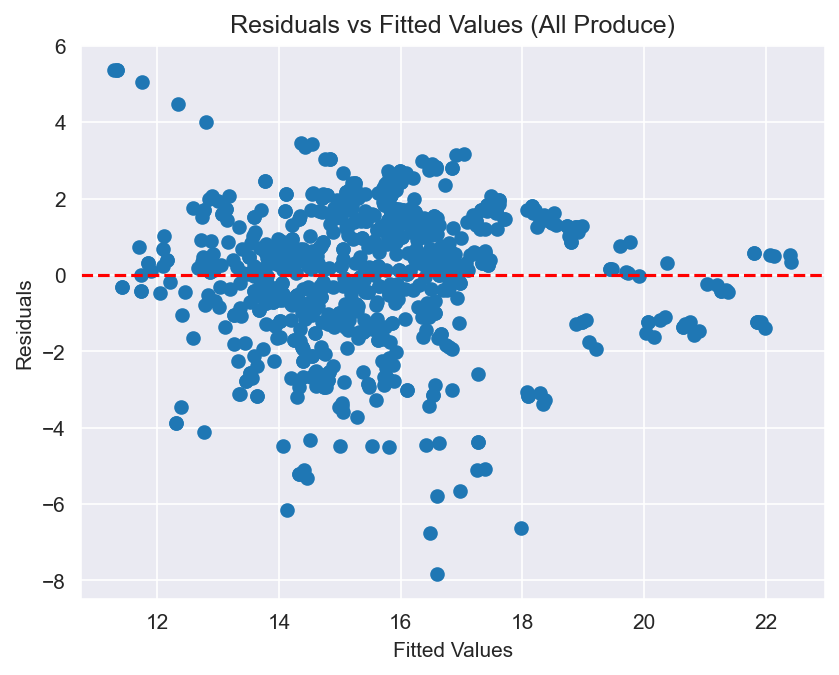

In [42]:
plt.scatter(model_all.fittedvalues, model_all.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (All Produce)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

##### 2. Normality of Errors (Histogram of Residuals and Q-Q plot)

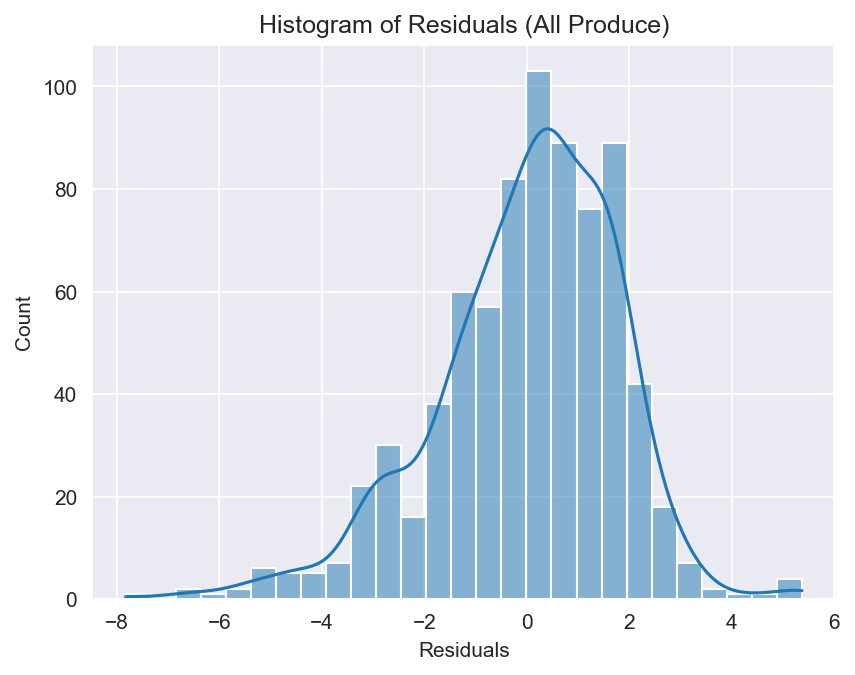

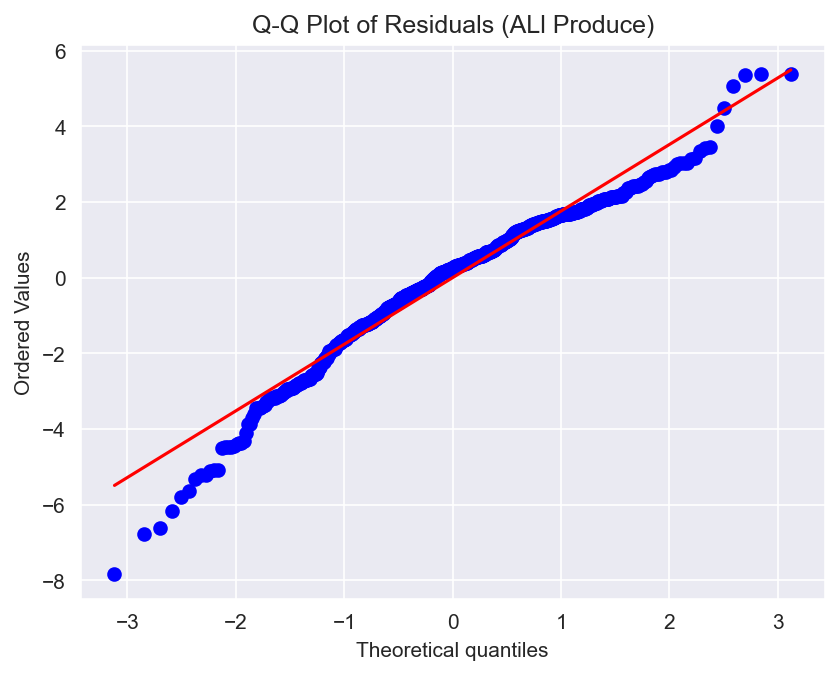

In [43]:
# standard residuals
sns.histplot(model_all.resid, kde=True)
plt.title('Histogram of Residuals (All Produce)')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot
stats.probplot(model_all.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (ALl Produce)')
plt.show()

### 1. What factors affect New Zealand's food exports? And how?

#### For Diary produce:

New Zealand's Diary exports are positively influenced by GDP, participation in Free Trade Agreements (FTAs), and strong trade relations with regions like Asia, North America, and Oceania. Freight costs also show a positive impact, which could reflect efficient trade logistics or high-value exports.

On the other hand, negative factors include average GDP, vaccination rates, and death rates, suggesting that these socio-economic indicators may present challenges to export performance. Exports to South America and Europe also negatively impact food exports, indicating potential difficulties in these markets, such as competition or market access issues.

Regarding the pandemic, the overall impact appears to be slightly negative, but the interaction with FTAs shows that these agreements may have helped mitigate some of the adverse effects, albeit to a small extent. This highlights the importance of economic growth, trade agreements, and regional market conditions in sustaining New Zealand's food export performance, particularly during global disruptions like the pandemic.


#### For Aquatic produce:
New Zealand's food exports benefit from strong economic factors such as GDP and average GDP, along with positive effects from trade agreements like FTAs. Additionally, regions like Africa and Oceania show a positive impact on food exports, highlighting favorable market conditions in these areas.

However, several factors negatively impact food exports, including vaccination rates, freight costs, inflation, and death rates. These economic and logistical challenges likely hinder export performance. Additionally, regions such as Asia, North America, and South America pose significant challenges, possibly due to competition, market access issues, or other region-specific barriers.

The effects of the pandemic on food exports appear to be slightly positive, but the interaction with FTAs indicates that these agreements has negative effects on the outputs. This underscores the need for robust strategies to enhance the resilience of New Zealand’s export sector during global crises.


#### For Fruit produce:
New Zealand's fruit exports are positively influenced by strong economic factors such as GDP, average GDP, and participation in Free Trade Agreements (FTAs). Additionally, regions like Asia and Oceania show positive effects, reflecting strong demand and favorable trade conditions in these markets.

Conversely, several factors negatively impact food exports. Higher freight costs, inflation, and death rates are detrimental to export performance, likely due to increased costs and economic disruptions. Furthermore, regions like Africa, North America, South America, and Europe show negative impacts, suggesting significant challenges in these markets, such as competition, logistical barriers, or economic instability.

The effects of the pandemic on food exports appear to be slightly negative, but the interaction with FTAs indicates that these agreements may have provided some support, helping to mitigate the pandemic’s adverse effects. Overall, the results highlight the importance of economic growth, trade agreements, and regional market conditions in sustaining and enhancing New Zealand's food export performance, even in the face of global disruptions like the pandemic.


#### For Meat produce:
New Zealand's meat exports benefit from strong economic indicators such as GDP and average GDP, along with participation in Free Trade Agreements (FTAs). The Oceania region is also a significant positive contributor to export performance, reflecting the advantages of geographical proximity and established trade networks.

However, several factors negatively influence food exports. High freight costs and increased death rates have a detrimental effect, possibly due to the associated costs and disruptions. Exports to Africa, North America, South America, and Europe also show negative impacts, indicating challenges such as competition, market access, or logistical difficulties in these regions.

Additionally, the pandemic itself negatively affects food exports, exacerbating the challenges faced by New Zealand's export sector. While FTAs provide some support, the pandemic's impact underscores the need for adaptive strategies to mitigate disruptions and leverage trade agreements effectively during global crises.


#### For Vegetable produce:
New Zealand's vegetable exports are positively influenced by strong economic performance indicators such as GDP and average GDP, as well as participation in Free Trade Agreements (FTAs). The Asian and Oceania markets also significantly boost food exports, reflecting strong demand and favorable trade conditions in these regions.

However, several factors negatively impact food exports, including higher freight costs, increased death rates, and challenges in regions like Africa, North America, South America, and Europe. These negative effects may stem from logistical issues, market competition, or economic disruptions in these areas.

Regarding the pandemic's impact, while the direct effect appears to be slightly positive, it is relatively minor. The interaction between the pandemic and FTAs shows a slight positive effect, indicating that FTAs may have provided some support during the pandemic, helping to cushion its impact on food exports. Overall, the results highlight the importance of economic growth, strategic trade agreements, and regional market conditions in determining the success of New Zealand's food exports, especially in times of global crisis.


#### For all trade produce:
The analysis shows that New Zealand's food exports benefit from strong economic performance indicators like GDP and average GDP, along with favorable conditions in regions such as Asia, Africa, North America, and Oceania. Participation in Free Trade Agreements (FTAs) and even freight costs are positively associated with higher food exports, which could reflect efficient trade logistics or high-value export markets.

On the other hand, the death rate, along with exports to South America and Europe, negatively impacts food exports. These regions may present specific challenges such as market access issues, competition, or economic instability.

The effects of the pandemic on food exports appear to be slightly negative, but the presence of FTAs might have provided some support, helping to buffer the pandemic's impact. Overall, the results highlight the importance of maintaining strong economic fundamentals and leveraging trade agreements to optimize New Zealand's food export performance, even during global disruptions.

### 2. Can Free Trade Agreement (FTA) help New Zealand export more food to its trade partners?

Yes, based on the linear regression model for all items, the coefficient for FTA in every situation is positive, which means FTA help New Zealand export more food to its trade partners 

### 3. How has COVID-19 affected New Zealand exports? (e.g. overall vs. each export item) (Combine the analysis in Q1 also)

The covid looks like is not a significant variable (p-value is large, also LASSO regression will show it is not a significant variable)

But just using coefficient:
* For Dairy produce: negative effect
* For Aquatic produce: positive effect
* For Fruit produce: negative effect
* For Meat produce: negative effect
* For Vegetable produce: positive effect
* for all trade: negative effect

If also consider death rate of COVID-19, we can find that for all output items, the death rate (COVID-19) has negative effect for the New Zealand food exports 

But all effect is really small and can be ignored

### 4. Can FTA offset the negative effect of COVID-19 on New Zealand exports? Or Can FTA boost the positive effect of COVID-19 on New Zealand exports? If so, how?

### All trade data

In [44]:
final_data.columns

Index(['year', 'country', 'dairy_produce', 'aquatic_produce', 'fruit_produce',
       'meat_produce', 'vegetable_produce', 'all_trade', 'GDP', 'avg_GDP',
       'vacc_rate', 'freight', 'inflation', 'death_rate', 'FTA', 'Asia',
       'Africa', 'North_America', 'South_America', 'Europe', 'Oceania',
       'pandemic', 'pandemic * FTA'],
      dtype='object')

In [45]:
model_formula = 'all_trade ~ FTA + pandemic + pandemic * FTA + GDP + avg_GDP + vacc_rate + freight + inflation + death_rate + Oceania + Asia + Africa + North_America + South_America + Europe'
model = smf.ols(formula=model_formula, data=final_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              all_trade   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     63.70
Date:                Sat, 31 Aug 2024   Prob (F-statistic):          2.42e-117
Time:                        22:32:52   Log-Likelihood:                -1530.5
No. Observations:                 766   AIC:                             3091.
Df Residuals:                     751   BIC:                             3161.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.3802      0.847     -7.533      0.000      -8.043      -4.718
FTA               0.9689      0.327      2.966      0.003       0.328       1.610
pandemic         -0.0970      0.144     -0.674      0.501      -0.379       0.185
pandemic:FTA      0.2133      0.412      0.517      0.605      -0.596       1.023
GDP               0.8303      0.039     21.448      0.000       0.754       0.906
avg_GDP           0.2526      0.072      3.524      0.000       0.112       0.393
vacc_rate        -0.0007      0.002     -0.315      0.753      -0.005       0.004
freight           0.0116      0.005      2.453      0.014       0.002       0.021
inflation         0.0020      0.003      0.600      0.549      -0.005       0.008
death_rate       -1.6818      1.782     -0.944      0.345      -5.179       1.816
Oceania           1.1635      0.206      5.636      0.000       0.758       1.569
Asia             -0.4472      0.216     -2.074      0.038      -0.871      -0.024
Africa           -0.7423      0.193     -3.837      0.000      -1.122      -0.363
North_America    -0.2185      0.205     -1.068      0.286      -0.620       0.183
South_America    -3.0878      0.299    -10.328      0.000      -3.675      -2.501
Europe           -3.0478      0.268    -11.382      0.000      -3.573      -2.522
==============================================================================
Omnibus:                       75.481   Durbin-Watson:                   1.709
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.427
Skew:                          -0.710   Prob(JB):                     3.86e-25
Kurtosis:                       4.228   Cond. No.                     3.09e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.06e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### FTA offset the negative effect, the FTA * pandemic indicates FTAs can indeed mitigate the negative impacts of COVID-19 on all exports

### Diary

In [46]:
model_formula = 'dairy_produce ~ FTA + pandemic + pandemic * FTA + GDP + avg_GDP + vacc_rate + freight + inflation + death_rate + Oceania + Asia + Africa + North_America + South_America + Europe'
model = smf.ols(formula=model_formula, data=final_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          dairy_produce   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     29.14
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           1.42e-61
Time:                        22:32:52   Log-Likelihood:                -2300.7
No. Observations:                 766   AIC:                             4631.
Df Residuals:                     751   BIC:                             4701.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -13.1374      2.315     -5.675      0.000     -17.682      -8.593
FTA               1.6382      0.893      1.835      0.067      -0.115       3.391
pandemic         -0.2702      0.393     -0.687      0.492      -1.042       0.502
pandemic:FTA      0.0746      1.127      0.066      0.947      -2.137       2.287
GDP               1.1712      0.106     11.069      0.000       0.964       1.379
avg_GDP          -0.1358      0.196     -0.693      0.489      -0.520       0.249
vacc_rate        -0.0010      0.006     -0.177      0.859      -0.013       0.010
freight           0.0368      0.013      2.852      0.004       0.011       0.062
inflation         0.0070      0.009      0.768      0.443      -0.011       0.025
death_rate       -1.0696      4.870     -0.220      0.826     -10.629       8.490
Oceania           2.3088      0.564      4.091      0.000       1.201       3.417
Asia             -1.0860      0.590     -1.842      0.066      -2.243       0.071
Africa           -2.4540      0.529     -4.641      0.000      -3.492      -1.416
North_America     1.5992      0.559      2.859      0.004       0.501       2.697
South_America    -5.2526      0.817     -6.428      0.000      -6.857      -3.648
Europe           -8.2528      0.732    -11.276      0.000      -9.690      -6.816
==============================================================================
Omnibus:                      137.823   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              215.331
Skew:                          -1.203   Prob(JB):                     1.74e-47
Kurtosis:                       3.981   Cond. No.                     3.09e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.06e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### FTA offset the negative effect, the FTA * pandemic indicates FTAs can indeed mitigate the negative impacts of COVID-19 on diary exports

### Aquatic

In [47]:
model_formula = 'aquatic_produce ~ FTA + pandemic + pandemic * FTA + GDP + avg_GDP + vacc_rate + freight + inflation + death_rate + Oceania + Asia + Africa + North_America + South_America + Europe'
model = smf.ols(formula=model_formula, data=final_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        aquatic_produce   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     28.26
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           6.91e-60
Time:                        22:32:52   Log-Likelihood:                -2399.5
No. Observations:                 766   AIC:                             4829.
Df Residuals:                     751   BIC:                             4899.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -22.1951      2.634     -8.427      0.000     -27.365     -17.025
FTA               3.7052      1.016      3.647      0.000       1.711       5.700
pandemic          0.1356      0.447      0.303      0.762      -0.743       1.014
pandemic:FTA     -0.0238      1.282     -0.019      0.985      -2.540       2.493
GDP               1.0780      0.120      8.955      0.000       0.842       1.314
avg_GDP           0.8710      0.223      3.908      0.000       0.433       1.309
vacc_rate        -0.0002      0.007     -0.033      0.974      -0.013       0.013
freight          -0.0210      0.015     -1.430      0.153      -0.050       0.008
inflation        -0.0116      0.010     -1.124      0.261      -0.032       0.009
death_rate       -6.7207      5.540     -1.213      0.225     -17.597       4.156
Oceania           2.6227      0.642      4.085      0.000       1.362       3.883
Asia             -4.6791      0.671     -6.976      0.000      -5.996      -3.362
Africa           -3.2986      0.602     -5.483      0.000      -4.480      -2.118
North_America    -7.3801      0.636    -11.596      0.000      -8.629      -6.131
South_America    -6.3308      0.930     -6.809      0.000      -8.156      -4.506
Europe           -3.1291      0.833     -3.758      0.000      -4.764      -1.494
==============================================================================
Omnibus:                       64.412   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.420
Skew:                          -0.284   Prob(JB):                     4.09e-07
Kurtosis:                       2.226   Cond. No.                     3.09e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.06e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### FTA did not boost the positive effect of COVID-19, the negative value of FTA * pandemic indicates FTAs reduces the positive effect of COVID-19 in aquatic output

### Fruit

In [48]:
model_formula = 'fruit_produce ~ FTA + pandemic + pandemic * FTA + GDP + avg_GDP + vacc_rate + freight + inflation + death_rate + Oceania + Asia + Africa + North_America + South_America + Europe'
model = smf.ols(formula=model_formula, data=final_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          fruit_produce   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     53.43
Date:                Sat, 31 Aug 2024   Prob (F-statistic):          1.23e-102
Time:                        22:32:52   Log-Likelihood:                -2323.4
No. Observations:                 766   AIC:                             4677.
Df Residuals:                     751   BIC:                             4746.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -29.6735      2.385    -12.444      0.000     -34.355     -24.992
FTA               4.5201      0.920      4.914      0.000       2.714       6.326
pandemic         -0.1358      0.405     -0.335      0.738      -0.931       0.660
pandemic:FTA     -0.1125      1.161     -0.097      0.923      -2.391       2.166
GDP               1.3432      0.109     12.323      0.000       1.129       1.557
avg_GDP           0.8534      0.202      4.229      0.000       0.457       1.250
vacc_rate         0.0051      0.006      0.847      0.397      -0.007       0.017
freight          -0.0115      0.013     -0.866      0.387      -0.038       0.015
inflation        -0.0259      0.009     -2.780      0.006      -0.044      -0.008
death_rate       -7.7734      5.016     -1.550      0.122     -17.621       2.074
Oceania           3.5491      0.581      6.106      0.000       2.408       4.690
Asia             -3.0543      0.607     -5.030      0.000      -4.246      -1.862
Africa           -7.1522      0.545    -13.130      0.000      -8.222      -6.083
North_America    -5.4326      0.576     -9.428      0.000      -6.564      -4.301
South_America    -9.2757      0.842    -11.019      0.000     -10.928      -7.623
Europe           -8.3078      0.754    -11.019      0.000      -9.788      -6.828
==============================================================================
Omnibus:                       29.416   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.649
Skew:                           0.221   Prob(JB):                     0.000147
Kurtosis:                       2.402   Cond. No.                     3.09e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.06e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### FTA offset the negative effect, the FTA * pandemic indicates FTAs can indeed mitigate the negative impacts of COVID-19 on Fruit exports

### Meat

In [49]:
model_formula = 'meat_produce ~ FTA + pandemic + pandemic * FTA + GDP + avg_GDP + vacc_rate + freight + inflation + death_rate + Oceania + Asia + Africa + North_America + South_America + Europe'
model = smf.ols(formula=model_formula, data=final_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           meat_produce   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     46.55
Date:                Sat, 31 Aug 2024   Prob (F-statistic):           5.52e-92
Time:                        22:32:52   Log-Likelihood:                -2412.1
No. Observations:                 766   AIC:                             4854.
Df Residuals:                     751   BIC:                             4924.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -31.0808      2.677    -11.610      0.000     -36.336     -25.825
FTA               2.1569      1.033      2.089      0.037       0.130       4.184
pandemic         -0.4788      0.455     -1.053      0.293      -1.372       0.414
pandemic:FTA      1.9746      1.303      1.515      0.130      -0.583       4.533
GDP               1.0736      0.122      8.774      0.000       0.833       1.314
avg_GDP           2.0977      0.227      9.258      0.000       1.653       2.542
vacc_rate        -0.0082      0.007     -1.205      0.229      -0.021       0.005
freight          -0.0613      0.015     -4.102      0.000      -0.091      -0.032
inflation         0.0070      0.010      0.673      0.501      -0.014       0.028
death_rate      -10.1238      5.632     -1.798      0.073     -21.179       0.932
Oceania           3.2885      0.653      5.039      0.000       2.007       4.570
Asia             -5.0466      0.682     -7.402      0.000      -6.385      -3.708
Africa           -5.3677      0.612     -8.778      0.000      -6.568      -4.167
North_America    -5.8988      0.647     -9.118      0.000      -7.169      -4.629
South_America   -13.0104      0.945    -13.767      0.000     -14.866     -11.155
Europe           -5.0459      0.846     -5.962      0.000      -6.707      -3.384
==============================================================================
Omnibus:                       20.670   Durbin-Watson:                   1.597
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.314
Skew:                          -0.146   Prob(JB):                      0.00212
Kurtosis:                       2.451   Cond. No.                     3.09e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.06e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### FTA offset the negative effect, the FTA * pandemic indicates FTAs can indeed mitigate the negative impacts of COVID-19 on meat exports

### Vegetable

In [50]:
model_formula = 'vegetable_produce ~ FTA + pandemic + pandemic * FTA + GDP + avg_GDP + vacc_rate + freight + inflation + death_rate + Oceania + Asia + Africa + North_America + South_America + Europe'
model = smf.ols(formula=model_formula, data=final_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      vegetable_produce   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     79.33
Date:                Sat, 31 Aug 2024   Prob (F-statistic):          1.69e-137
Time:                        22:32:52   Log-Likelihood:                -2188.9
No. Observations:                 766   AIC:                             4408.
Df Residuals:                     751   BIC:                             4477.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -32.5364      2.000    -16.265      0.000     -36.463     -28.609
FTA               3.5239      0.772      4.567      0.000       2.009       5.039
pandemic          0.3948      0.340      1.162      0.246      -0.272       1.062
pandemic:FTA      0.5074      0.974      0.521      0.602      -1.404       2.419
GDP               1.4515      0.091     15.874      0.000       1.272       1.631
avg_GDP           0.9714      0.169      5.738      0.000       0.639       1.304
vacc_rate        -0.0074      0.005     -1.464      0.144      -0.017       0.003
freight          -0.0565      0.011     -5.058      0.000      -0.078      -0.035
inflation         0.0055      0.008      0.703      0.482      -0.010       0.021
death_rate      -11.3984      4.208     -2.709      0.007     -19.659      -3.137
Oceania           5.2921      0.488     10.853      0.000       4.335       6.249
Asia             -4.7241      0.509     -9.273      0.000      -5.724      -3.724
Africa           -6.4108      0.457    -14.029      0.000      -7.308      -5.514
North_America    -9.3727      0.483    -19.389      0.000     -10.322      -8.424
South_America    -8.6367      0.706    -12.230      0.000     -10.023      -7.250
Europe           -8.6842      0.632    -13.731      0.000      -9.926      -7.443
==============================================================================
Omnibus:                        0.735   Durbin-Watson:                   1.485
Prob(Omnibus):                  0.692   Jarque-Bera (JB):                0.826
Skew:                           0.059   Prob(JB):                        0.662
Kurtosis:                       2.891   Cond. No.                     3.09e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.06e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### FTA boost the positive effect of COVID-19, both the positive value of pandemic and the FTA * pandemic indicates FTAs can indeed boost the positive impacts of COVID-19 on vegetable exports

$${Export\_item} = \alpha_0 + \alpha_1 \cdot {FTA} + \alpha_2 \cdot {pandemic} + \alpha_3 \cdot ({pandemic} \times {FTA}) + \alpha_4 \cdot \text{GDP} + \alpha_5 \cdot {avg\_GDP} + \alpha_6 \cdot {vacc\_rate} + \alpha_7 \cdot {freight} + \alpha_8 \cdot {inflation} + \alpha_9 \cdot {death\_rate} + \alpha_{10} \cdot {Oceania} + \alpha_{11} \cdot {Asia} + \alpha_{12} \cdot {Africa} + \alpha_{13} \cdot {North\_America} + \alpha_{14} \cdot {South\_America} + \alpha_{15} \cdot {Europe}$$